In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import StratifiedShuffleSplit
import random
from sklearn.metrics import f1_score, confusion_matrix

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-08-26 07:18:02.965398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 07:18:03.541027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-26 07:18:03.795379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been register

In [2]:
CSV_PATH = Path("dev_data_2025.csv")
IMG_DIR = Path("Hematoxylin")

In [3]:
MAX_IMAGES_FOR_SIZE_SCAN = 10500
MAX_IMAGES_FOR_HEATMAP = 10500
HEATMAP_RES = (128, 128)
BORDER_RATIO = 0.10

IMG_SIZE = 350  # final size after crop
BATCH = 16
EPOCHS = 40

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# Aug params (very light)
ROTATION = 0.08     # ~±15°
BRIGHT_D = 0.05     # brightness delta
CONTRAST = 0.10     # contrast factor

In [5]:
data = pd.read_csv(CSV_PATH)
print("Shape:", data.shape)
print(data.head())
print("\nMissing values:\n", data.isna().sum())

Shape: (5000, 5)
     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole
0  Img_00001  Lymphocyte      round     unsegmented-round                no
1  Img_00002    Monocyte  irregular  unsegmented-indented                no
2  Img_00003    Monocyte  irregular             irregular               yes
3  Img_00004    Basophil      round  segmented-multilobed                no
4  Img_00005  Neutrophil      round      unsegmented-band                no

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
dtype: int64


In [6]:
file_count = len([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])

print(f"Number of files in '{IMG_DIR}': {file_count}")

Number of files in 'Hematoxylin': 10298


#### There is a difference between the number of images given and the labels provided.
#### Less than half of the images are labeled.

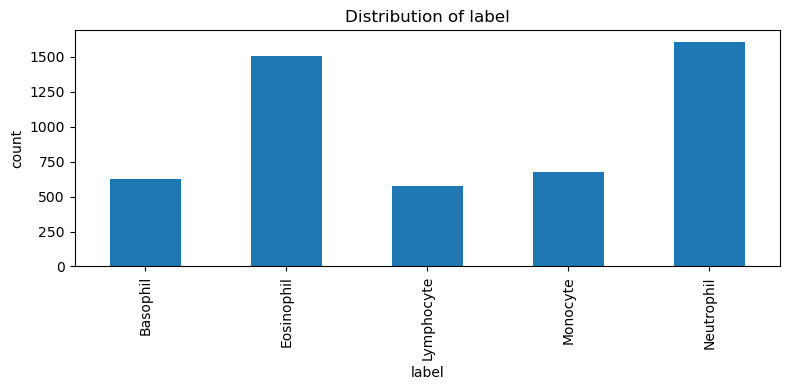

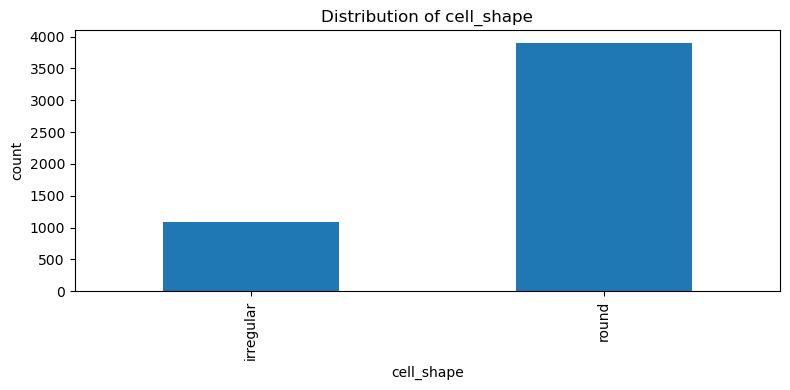

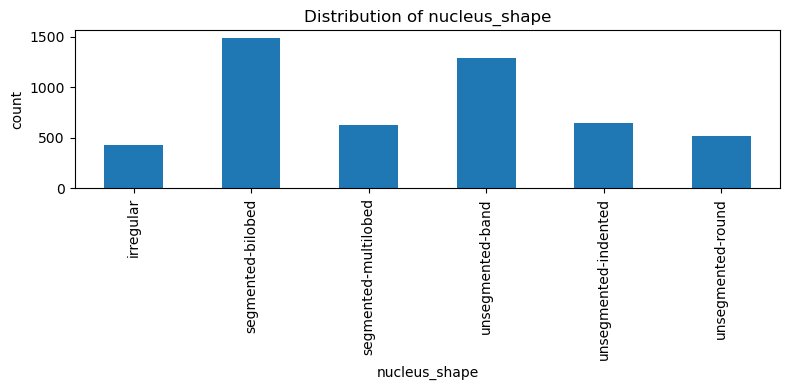

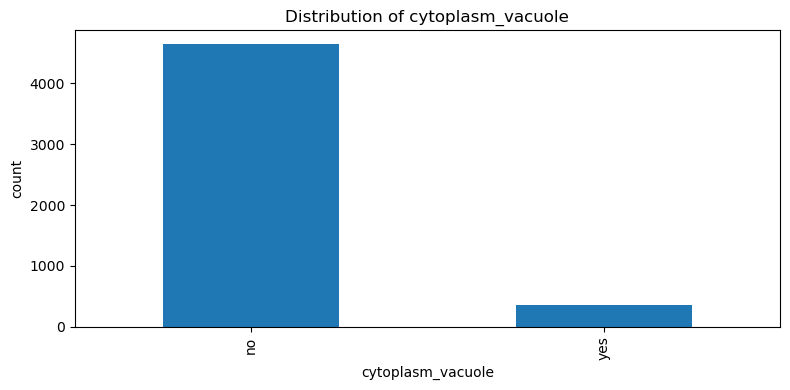

In [7]:
for col in ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]:
    counts = data[col].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    counts.plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

#### All classificasions are imbalanced

In [8]:
sizes = []
for i, row in data.iterrows():
    img_id = row["imageID"]
    path = IMG_DIR / f"{img_id}.jpg"
    if not path.exists():
        continue
    with Image.open(path) as im:
        sizes.append((im.width, im.height))
    if len(sizes) >= MAX_IMAGES_FOR_SIZE_SCAN:
        break

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
print("\nImage size frequencies:\n", sizes_df.value_counts().head())


Image size frequencies:
 width  height
360    363       4875
366    369        125
Name: count, dtype: int64


#### Images are of 2 different sizes

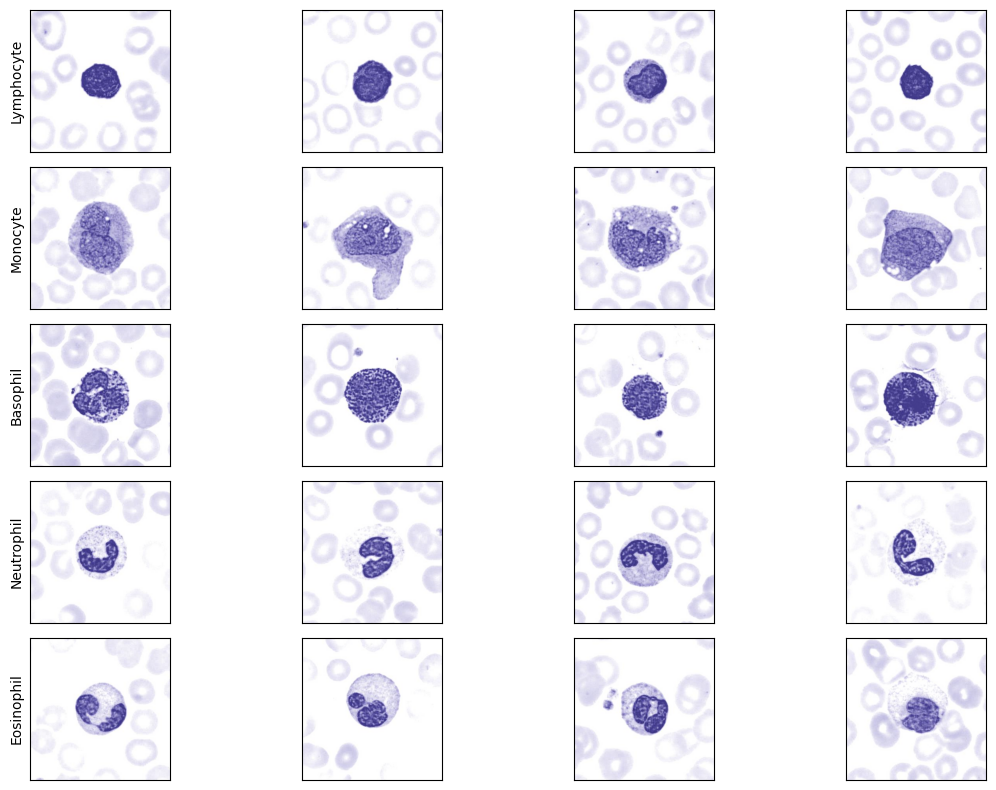

In [9]:
classes = data["label"].unique()[:5]
plt.figure(figsize=(12, 8))
for idx, cls in enumerate(classes):
    subset = data[data["label"] == cls].head(4)
    for j, row in enumerate(subset.itertuples()):
        path = IMG_DIR / f"{row.imageID}.jpg"
        with Image.open(path) as im:
            plt.subplot(len(classes), 4, idx*4+j+1)
            plt.imshow(im)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            if j == 0:
                plt.ylabel(cls)
plt.tight_layout()
plt.show()

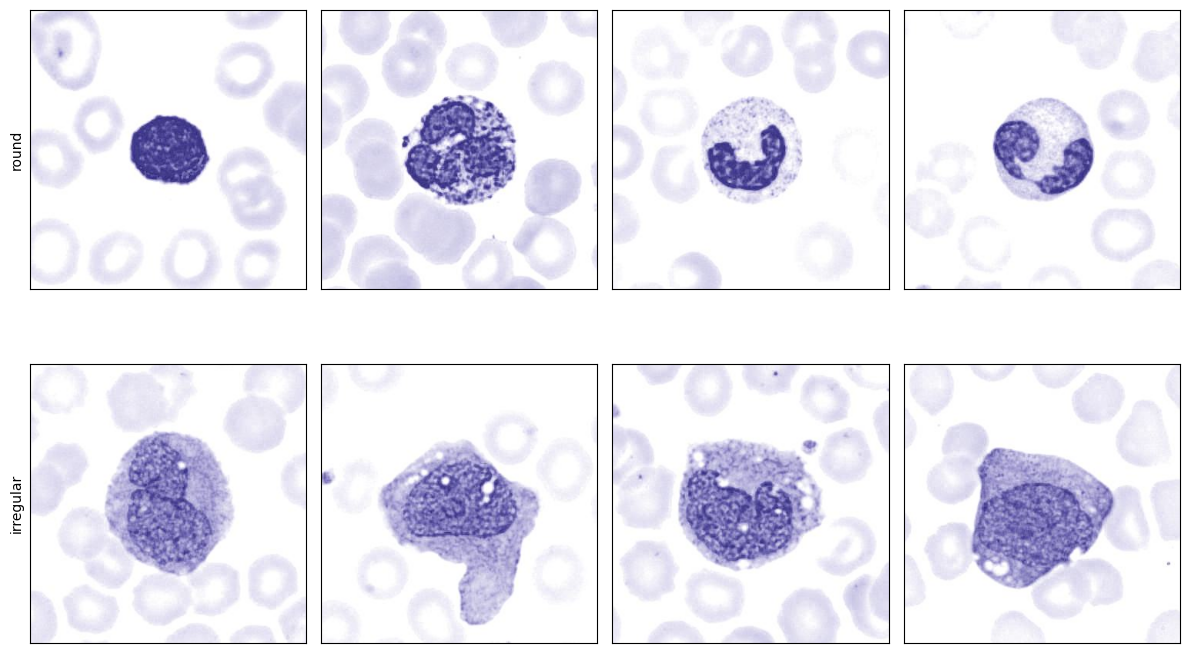

In [10]:
classes = data["cell_shape"].unique()[:5]
plt.figure(figsize=(12, 8))
for idx, cls in enumerate(classes):
    subset = data[data["cell_shape"] == cls].head(4)
    for j, row in enumerate(subset.itertuples()):
        path = IMG_DIR / f"{row.imageID}.jpg"
        with Image.open(path) as im:
            plt.subplot(len(classes), 4, idx*4+j+1)
            plt.imshow(im)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            if j == 0:
                plt.ylabel(cls)
plt.tight_layout()
plt.show()

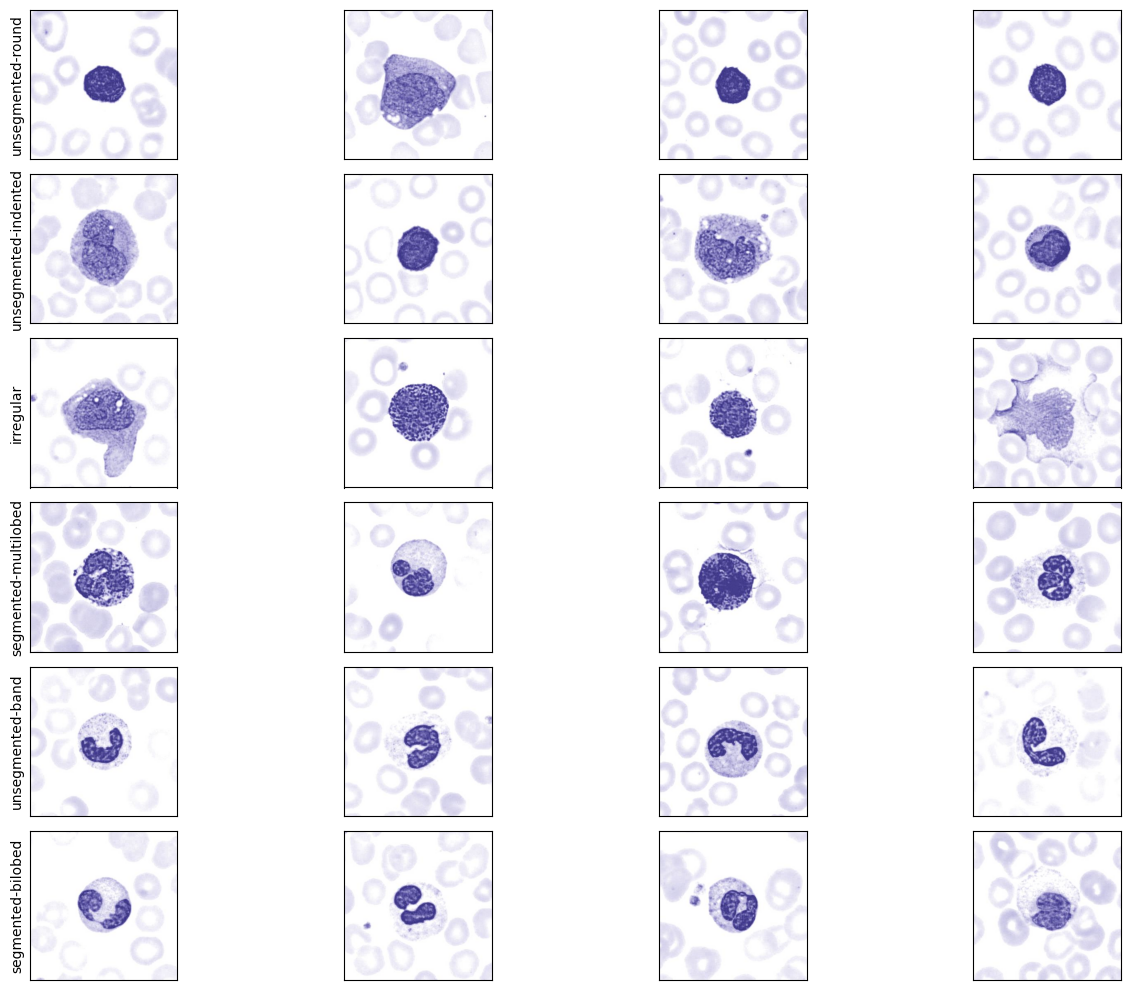

In [43]:
classes = data["nucleus_shape"].unique()[:6]
plt.figure(figsize=(14, 10))
for idx, cls in enumerate(classes):
    subset = data[data["nucleus_shape"] == cls].head(4)
    for j, row in enumerate(subset.itertuples()):
        path = IMG_DIR / f"{row.imageID}.jpg"
        with Image.open(path) as im:
            plt.subplot(len(classes), 4, idx*4+j+1)
            plt.imshow(im)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            if j == 0:
                plt.ylabel(cls)
plt.tight_layout()
plt.show()

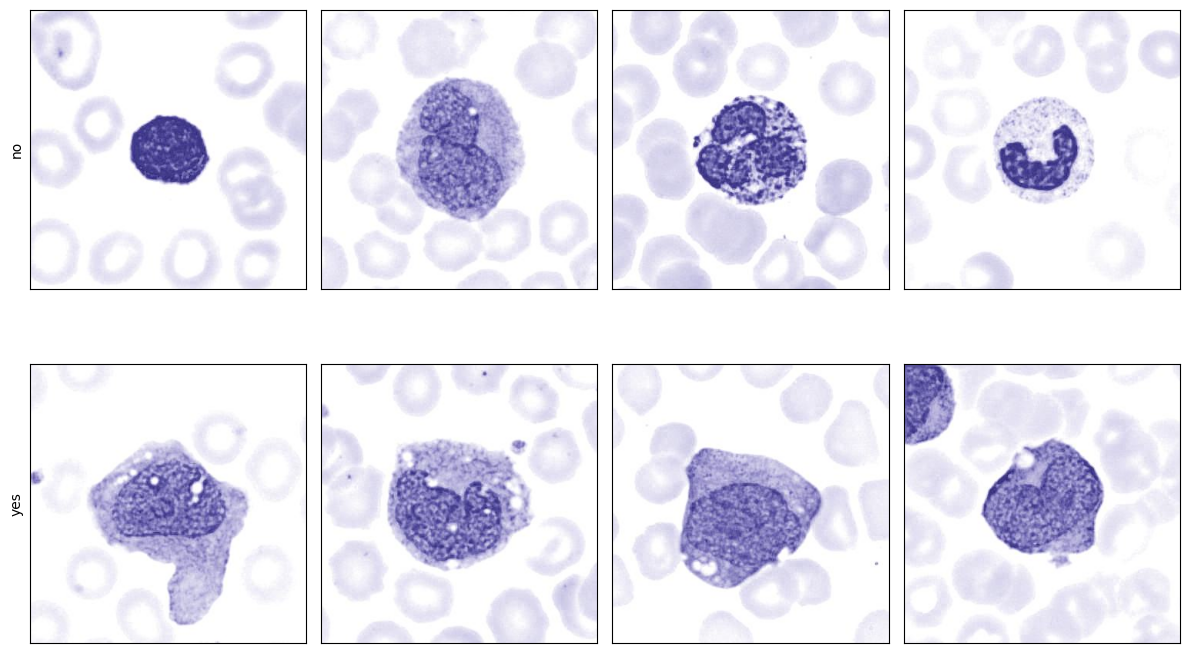

In [12]:
classes = data["cytoplasm_vacuole"].unique()[:5]
plt.figure(figsize=(12, 8))
for idx, cls in enumerate(classes):
    subset = data[data["cytoplasm_vacuole"] == cls].head(4)
    for j, row in enumerate(subset.itertuples()):
        path = IMG_DIR / f"{row.imageID}.jpg"
        with Image.open(path) as im:
            plt.subplot(len(classes), 4, idx*4+j+1)
            plt.imshow(im)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            if j == 0:
                plt.ylabel(cls)
plt.tight_layout()
plt.show()

In [13]:
def load_resized_with_meta(df, img_dir: Path, n=MAX_IMAGES_FOR_HEATMAP, size=HEATMAP_RES):
    X, kept_rows = [], []
    for i, row in df.iterrows():
        p = img_dir / f"{row.imageID}.jpg"
        if not p.exists():
            continue
        try:
            with Image.open(p) as im:
                im = ImageOps.exif_transpose(im).convert("RGB").resize(size)
                X.append(np.asarray(im, dtype=np.float32)/255.0)
                kept_rows.append(row)
        except Exception:
            continue
        if len(X) >= n:
            break
    if len(X) == 0:
        return np.empty((0, size[1], size[0], 3), dtype=np.float32), pd.DataFrame()
    return np.stack(X), pd.DataFrame(kept_rows)

def to_gray(X): 
    return 0.299*X[...,0] + 0.587*X[...,1] + 0.114*X[...,2]


In [14]:
def anova_fmap(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Univariate ANOVA-like F-score per pixel for multi-class targets."""
    gray = to_gray(X)  # (N,H,W)
    N, H, W = gray.shape
    classes = np.unique(y)
    k = len(classes)
    overall = gray.mean(axis=0)
    SSB = np.zeros((H, W), dtype=np.float64)
    SSW = np.zeros((H, W), dtype=np.float64)
    for c in classes:
        idx = (y == c)
        if idx.sum() < 2:
            continue
        grp = gray[idx]
        mean_c = grp.mean(axis=0)
        Nc = grp.shape[0]
        SSB += Nc * (mean_c - overall)**2
        SSW += ((grp - mean_c)**2).sum(axis=0)
    dfb = max(k - 1, 1)
    dfw = max(N - k, 1)
    MSB = SSB / dfb
    MSW = SSW / dfw
    with np.errstate(divide='ignore', invalid='ignore'):
        F = MSB / (MSW + 1e-8)
        F[~np.isfinite(F)] = 0.0
    return F

def binary_tscore_map(X: np.ndarray, ybin: np.ndarray) -> np.ndarray:
    """Absolute Welch's t per pixel for binary targets."""
    gray = to_gray(X)
    g0, g1 = gray[ybin == 0], gray[ybin == 1]
    if g0.shape[0] < 3 or g1.shape[0] < 3:
        return np.zeros(gray.shape[1:], dtype=np.float32)
    m0, v0, n0 = g0.mean(axis=0), g0.var(axis=0), g0.shape[0]
    m1, v1, n1 = g1.mean(axis=0), g1.var(axis=0), g1.shape[0]
    with np.errstate(divide='ignore', invalid='ignore'):
        t = (m0 - m1) / np.sqrt((v0/n0) + (v1/n1) + 1e-12)
        t[~np.isfinite(t)] = 0.0
    return np.abs(t)

def border_center_mask(shape, ratio: float):
    H, W = shape
    bh, bw = max(1, int(H*ratio)), max(1, int(W*ratio))
    mask = np.zeros((H, W), dtype=bool)
    mask[:bh,:] = True; mask[-bh:,:] = True; mask[:,:bw] = True; mask[:,-bw:] = True
    return mask, ~mask

def radial_profile(arr: np.ndarray, nbins: int = 20):
    """Compute mean arr value as a function of normalized radius (0 center → 1 edge)."""
    H, W = arr.shape
    cy, cx = (H-1)/2.0, (W-1)/2.0
    yy, xx = np.indices((H, W))
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    r_norm = r / r.max()
    bins = np.linspace(0, 1, nbins+1)
    prof = np.zeros(nbins, dtype=np.float64)
    for i in range(nbins):
        m = (r_norm >= bins[i]) & (r_norm < bins[i+1])
        if m.sum() > 0:
            prof[i] = arr[m].mean()
        else:
            prof[i] = np.nan
    centers = 0.5*(bins[:-1] + bins[1:])
    return centers, prof

def show_heatmap(arr: np.ndarray, title: str):
    plt.figure(figsize=(6,5))
    plt.imshow(arr, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.axis("off")
    plt.show()

def bar_border_center(arr: np.ndarray, title: str, ratio: float = BORDER_RATIO):
    bmask, cmask = border_center_mask(arr.shape, ratio)
    bmean, cmean = float(arr[bmask].mean()), float(arr[cmask].mean())
    plt.figure(figsize=(5,4))
    plt.bar(["Border", "Center"], [bmean, cmean])
    plt.title(f"{title}\n(mean discriminative value)")
    plt.ylabel("Mean value")
    plt.tight_layout()
    plt.show()
    print(f"{title}: border_mean={bmean:.6f}, center_mean={cmean:.6f}")
    return bmean, cmean

def line_radial(arr: np.ndarray, title: str, nbins: int = 20):
    r, prof = radial_profile(arr, nbins=nbins)
    plt.figure(figsize=(6,4))
    plt.plot(r, prof, marker="o")
    plt.title(f"Radial profile — {title}")
    plt.xlabel("Normalized radius (0=center, 1=edge)")
    plt.ylabel("Mean discriminative value")
    plt.tight_layout()
    plt.show()

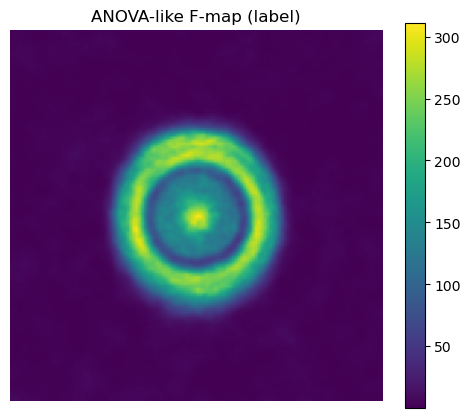

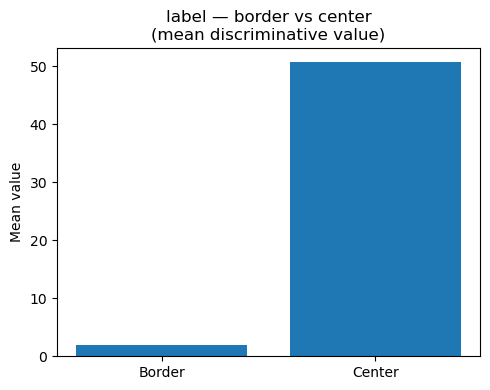

label — border vs center: border_mean=2.001557, center_mean=50.630051


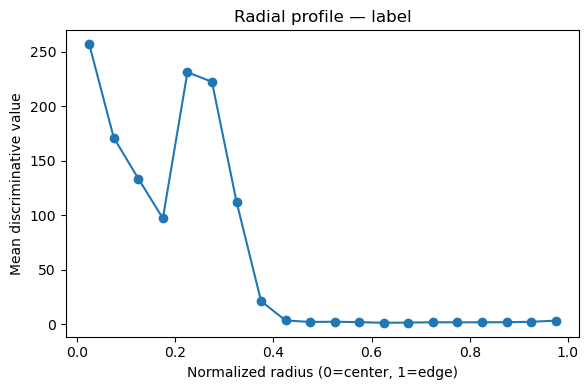

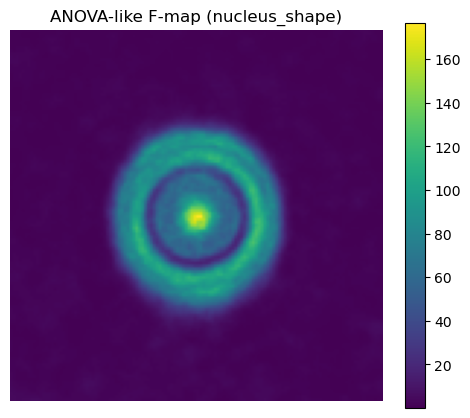

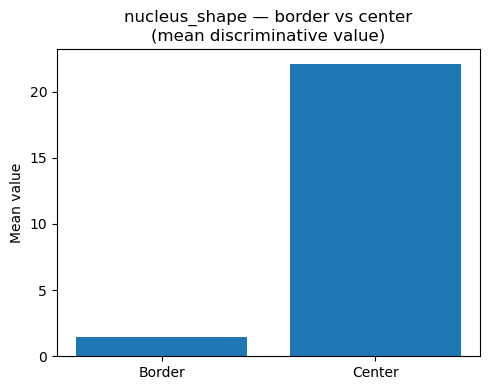

nucleus_shape — border vs center: border_mean=1.447652, center_mean=22.112746


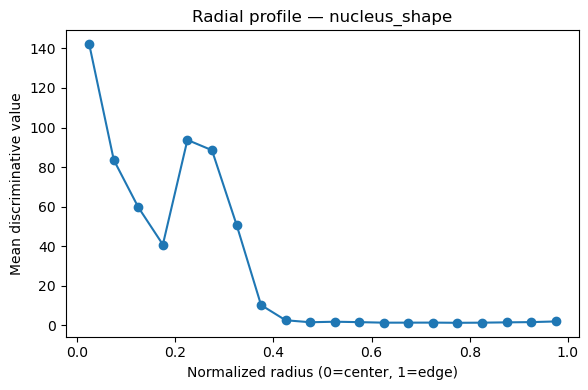

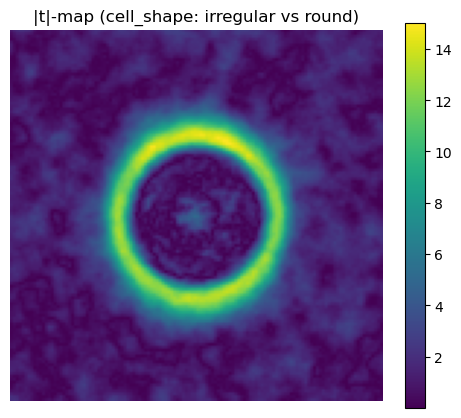

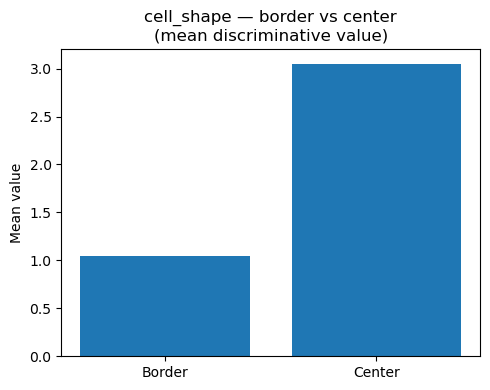

cell_shape — border vs center: border_mean=1.043819, center_mean=3.052180


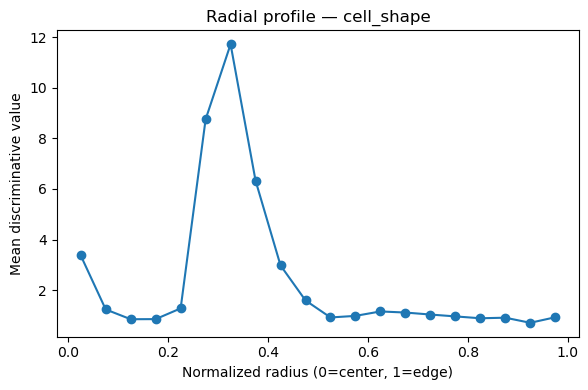

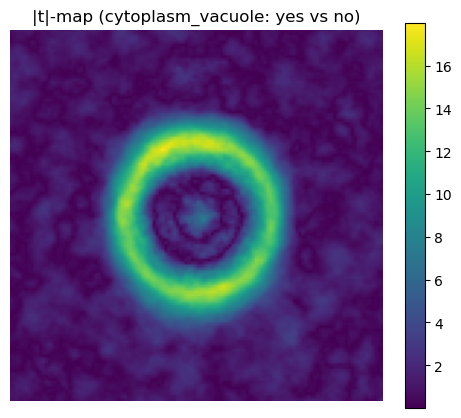

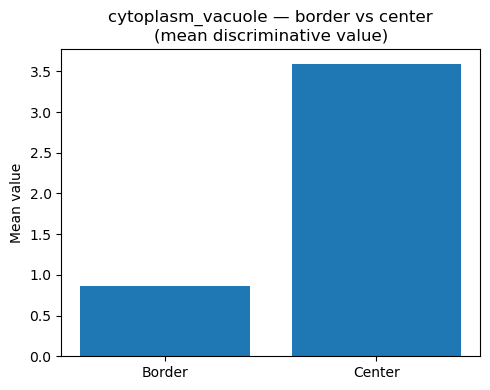

cytoplasm_vacuole — border vs center: border_mean=0.858103, center_mean=3.596202


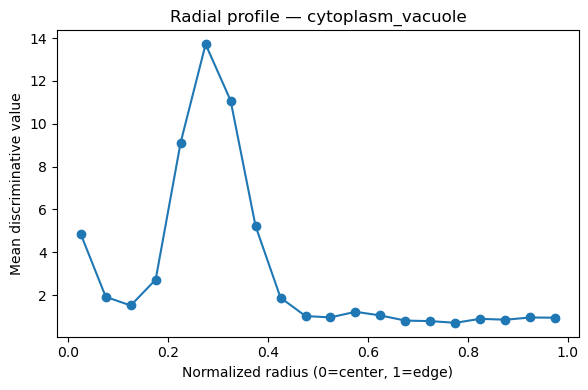

In [15]:
X, meta = load_resized_with_meta(data, IMG_DIR, n=MAX_IMAGES_FOR_HEATMAP, size=HEATMAP_RES)
targets = []

if "label" in meta.columns:
    targets.append(("label", "multiclass"))
if "nucleus_shape" in meta.columns:
    # Use only if at least 3 categories present
    if meta["nucleus_shape"].nunique(dropna=True) >= 3:
        targets.append(("nucleus_shape", "multiclass"))
if "cell_shape" in meta.columns:
    targets.append(("cell_shape", "binary"))
if "cytoplasm_vacuole" in meta.columns:
    targets.append(("cytoplasm_vacuole", "binary"))

summary_rows = []

for col, kind in targets:
    vals = meta[col].astype(str).str.lower()
    if kind == "multiclass":
        cats = sorted(vals.dropna().unique().tolist())
        if len(cats) < 2:
            continue
        mapping = {v:i for i,v in enumerate(cats)}
        y = vals.map(mapping).to_numpy()
        F = anova_fmap(X, y)
        show_heatmap(F, f"ANOVA-like F-map ({col})")
        b, c = bar_border_center(F, f"{col} — border vs center", ratio=BORDER_RATIO)
        line_radial(F, f"{col}")
        summary_rows.append({"target": col, "type": "multiclass", "border_mean": b, "center_mean": c})
    else:  # binary
        if col == "cell_shape":
            ok = vals.isin(["round", "irregular"]).to_numpy()
            if ok.sum() < 10: 
                continue
            yb = (vals == "irregular").to_numpy().astype(int)
            T = binary_tscore_map(X[ok], yb[ok])
            show_heatmap(T, f"|t|-map ({col}: irregular vs round)")
            b, c = bar_border_center(T, f"{col} — border vs center", ratio=BORDER_RATIO)
            line_radial(T, f"{col}")
            summary_rows.append({"target": col, "type": "binary", "border_mean": b, "center_mean": c})
        elif col == "cytoplasm_vacuole":
            ok = vals.isin(["yes", "no"]).to_numpy()
            if ok.sum() < 10:
                continue
            yb = (vals == "yes").to_numpy().astype(int)
            T = binary_tscore_map(X[ok], yb[ok])
            show_heatmap(T, f"|t|-map ({col}: yes vs no)")
            b, c = bar_border_center(T, f"{col} — border vs center", ratio=BORDER_RATIO)
            line_radial(T, f"{col}")
            summary_rows.append({"target": col, "type": "binary", "border_mean": b, "center_mean": c})



In [16]:
if summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    print("\n=== Border vs Center Summary ===")
    print(summary_df.to_string(index=False))


=== Border vs Center Summary ===
           target       type  border_mean  center_mean
            label multiclass     2.001557    50.630051
    nucleus_shape multiclass     1.447652    22.112746
       cell_shape     binary     1.043819     3.052180
cytoplasm_vacuole     binary     0.858103     3.596202


In [7]:
# =========================
# 1) Stratified split (by label)
# =========================
# Keep only rows with all targets present
cols_needed = ["imageID","label","cell_shape","nucleus_shape","cytoplasm_vacuole"]
df = data.dropna(subset=cols_needed).copy()

# Standardize strings a bit
df["label"] = df["label"].astype(str).str.strip()
df["cell_shape"] = df["cell_shape"].astype(str).str.strip().str.lower()
df["nucleus_shape"] = df["nucleus_shape"].astype(str).str.strip().str.lower()
df["cytoplasm_vacuole"] = df["cytoplasm_vacuole"].astype(str).str.strip().str.lower()

# 70/30 then 50/50 on the 30
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
idx_tr, idx_hold = next(sss1.split(df, df["label"]))
train_df = df.iloc[idx_tr].reset_index(drop=True)
hold_df  = df.iloc[idx_hold].reset_index(drop=True)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
idx_val, idx_test = next(sss2.split(hold_df, hold_df["label"]))
val_df  = hold_df.iloc[idx_val].reset_index(drop=True)
test_df = hold_df.iloc[idx_test].reset_index(drop=True)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print(train_df["label"].value_counts().sort_index())
print(val_df["label"].value_counts().sort_index())
print(test_df["label"].value_counts().sort_index())


Split sizes: 3500 750 750
label
Basophil       440
Eosinophil    1053
Lymphocyte     405
Monocyte       475
Neutrophil    1127
Name: count, dtype: int64
label
Basophil       94
Eosinophil    226
Lymphocyte     87
Monocyte      102
Neutrophil    241
Name: count, dtype: int64
label
Basophil       94
Eosinophil    225
Lymphocyte     87
Monocyte      102
Neutrophil    242
Name: count, dtype: int64


In [8]:
# =========================
# 2) Encoders
# =========================
# Multi-class label maps
label_classes = sorted(train_df["label"].unique().tolist())
label_to_idx  = {c:i for i,c in enumerate(label_classes)}
num_label     = len(label_classes)

nuc_classes = sorted(train_df["nucleus_shape"].unique().tolist())
nuc_to_idx  = {c:i for i,c in enumerate(nuc_classes)}
num_nuc     = len(nuc_classes)

# Binary encoders
def enc_cell_shape(x):  # 1 = irregular, 0 = round
    return 1 if str(x).lower() == "irregular" else 0

def enc_vac(x):         # 1 = yes, 0 = no
    return 1 if str(x).lower() == "yes" else 0


In [9]:
# =========================
# 3) I/O, center crop, augment
# =========================
AUTOTUNE = tf.data.AUTOTUNE

def decode_center_crop_350(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]

    h = tf.shape(img)[0]; w = tf.shape(img)[1]; target = IMG_SIZE
    scale = tf.maximum(target/tf.cast(h,tf.float32), target/tf.cast(w,tf.float32))
    nh = tf.cast(tf.math.round(tf.cast(h,tf.float32)*scale), tf.int32)
    nw = tf.cast(tf.math.round(tf.cast(w,tf.float32)*scale), tf.int32)
    img = tf.image.resize(img, (nh, nw), method="bilinear")

    off_y = (tf.shape(img)[0] - target) // 2
    off_x = (tf.shape(img)[1] - target) // 2
    img = tf.image.crop_to_bounding_box(img, off_y, off_x, target, target)  # 350x350
    return img  # [0,1]

# Aug: flip, rotation, very light brightness/contrast
aug_block = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    layers.RandomRotation(ROTATION, fill_mode="reflect", seed=SEED),
], name="aug_geom")

def light_photo_aug(x):
    # very light brightness/contrast
    x = tf.image.random_brightness(x, max_delta=BRIGHT_D)
    x = tf.image.random_contrast(x, lower=1.0-CONTRAST, upper=1.0+CONTRAST)
    return tf.clip_by_value(x, 0.0, 1.0)

def preprocess_for_mobilenet(x):
    # mobilenet_v2.preprocess_input expects [0..255], outputs [-1,1]
    return mobilenet_v2.preprocess_input(x*255.0)

def make_ds(df_in, shuffle=False, augment=False):
    paths = [str(IMG_DIR / f"{rid}.jpg") for rid in df_in["imageID"].tolist()]
    y_label = df_in["label"].map(label_to_idx).astype(int).values
    y_nuc   = df_in["nucleus_shape"].map(nuc_to_idx).astype(int).values
    y_cell  = df_in["cell_shape"].apply(enc_cell_shape).astype(int).values
    y_vac   = df_in["cytoplasm_vacuole"].apply(enc_vac).astype(int).values

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_nuc, y_cell, y_vac))

    def _map(p, yl, yn, yc, yv):
        x = decode_center_crop_350(p)
        if augment:
            x = aug_block(x, training=True)
            x = light_photo_aug(x)
        x = preprocess_for_mobilenet(x)

        y = {
            "label":   tf.one_hot(yl, num_label),
            "nucleus": tf.one_hot(yn, num_nuc),
            "cell":    tf.cast(tf.expand_dims(yc, -1), tf.float32),
            "vacuole": tf.cast(tf.expand_dims(yv, -1), tf.float32),
        }
        return x, y

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(8192, seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds(train_df, shuffle=True,  augment=True)
val_ds   = make_ds(val_df,   shuffle=False, augment=False)
test_ds  = make_ds(test_df,  shuffle=False, augment=False)


2025-08-26 07:18:44.470348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-26 07:18:44.896501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-26 07:18:44.901677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
# =========================
# 4) Model factory (dropout as HP)
# =========================
def build_model(dropout_rate=0.3):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base = mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_tensor=inp)
    base.trainable = False  # frozen backbone

    z = layers.GlobalAveragePooling2D()(base.output)
    z = layers.BatchNormalization()(z)
    z = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(z)
    z = layers.Dropout(dropout_rate)(z)
    z = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(z)

    out_label   = layers.Dense(num_label, activation="softmax", name="label")(z)
    out_nucleus = layers.Dense(num_nuc,   activation="softmax", name="nucleus")(z)
    out_cell    = layers.Dense(1,         activation="sigmoid", name="cell")(z)
    out_vacuole = layers.Dense(1,         activation="sigmoid", name="vacuole")(z)

    model = models.Model(inp, [out_label, out_nucleus, out_cell, out_vacuole])
    losses = {
        "label":   keras.losses.CategoricalCrossentropy(),
        "nucleus": keras.losses.CategoricalCrossentropy(),
        "cell":    keras.losses.BinaryCrossentropy(),
        "vacuole": keras.losses.BinaryCrossentropy(),
    }
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        # optional quick metrics (not used for stopping)
        weighted_metrics=[]
    )
    return model


In [11]:
# =========================
# 5) Callback: macro-F1 per head + composite for early stopping / LR decay
# =========================
class MultiHeadValMetrics(keras.callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true = {"label":[], "nucleus":[], "cell":[], "vacuole":[]}
        y_pred = {"label":[], "nucleus":[], "cell":[], "vacuole":[]}

        for xb, yb in self.val_ds:
            pl, pn, pc, pv = self.model.predict(xb, verbose=0)
            y_true["label"].extend(tf.argmax(yb["label"], axis=-1).numpy().tolist())
            y_true["nucleus"].extend(tf.argmax(yb["nucleus"], axis=-1).numpy().tolist())
            y_true["cell"].extend(tf.squeeze(yb["cell"], axis=-1).numpy().tolist())
            y_true["vacuole"].extend(tf.squeeze(yb["vacuole"], axis=-1).numpy().tolist())

            y_pred["label"].extend(np.argmax(pl, axis=-1).tolist())
            y_pred["nucleus"].extend(np.argmax(pn, axis=-1).tolist())
            y_pred["cell"].extend((pc.ravel() >= 0.5).astype(int).tolist())
            y_pred["vacuole"].extend((pv.ravel() >= 0.5).astype(int).tolist())

        f1_label   = f1_score(y_true["label"],   y_pred["label"],   average="macro")
        f1_nucleus = f1_score(y_true["nucleus"], y_pred["nucleus"], average="macro")
        f1_cell    = f1_score(y_true["cell"],    y_pred["cell"],    average="binary")
        f1_vacuole = f1_score(y_true["vacuole"], y_pred["vacuole"], average="binary")
        overall    = float(np.mean([f1_label, f1_nucleus, f1_cell, f1_vacuole]))

        logs["val_label_macro_f1"]   = f1_label
        logs["val_nucleus_macro_f1"] = f1_nucleus
        logs["val_cell_f1"]          = f1_cell
        logs["val_vacuole_f1"]       = f1_vacuole
        logs["val_overall"]          = overall

        # make them available in History too
        self.model.history.history.setdefault("val_label_macro_f1", []).append(f1_label)
        self.model.history.history.setdefault("val_nucleus_macro_f1", []).append(f1_nucleus)
        self.model.history.history.setdefault("val_cell_f1", []).append(f1_cell)
        self.model.history.history.setdefault("val_vacuole_f1", []).append(f1_vacuole)
        self.model.history.history.setdefault("val_overall", []).append(overall)

        print(f"[Val] F1(label)={f1_label:.3f} | F1(nucleus)={f1_nucleus:.3f} | "
              f"F1(cell)={f1_cell:.3f} | F1(vacuole)={f1_vacuole:.3f} | overall={overall:.3f}")

val_cb      = MultiHeadValMetrics(val_ds)
early_cb    = keras.callbacks.EarlyStopping(monitor="val_overall", mode="max", patience=7, restore_best_weights=True)
plateau_cb  = keras.callbacks.ReduceLROnPlateau(monitor="val_overall", mode="max", factor=0.5, patience=3, verbose=1)


In [26]:
# =========================
# 6) Train frozen backbone once (baseline)
# =========================
model = build_model(dropout_rate=0.3)
hist_base = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[val_cb, plateau_cb, early_cb],  # order matters: val_cb first
    verbose=1
)


Epoch 1/40


2025-08-26 03:56:46.638479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2363 of 8192
2025-08-26 03:56:51.386386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 53s 256ms/step - loss: 2.5046 - label_loss: 0.5765 - nucleus_loss: 1.3024 - cell_loss: 0.3746 - vacuole_loss: 0.1899 - val_loss: 2.3420 - val_label_loss: 0.5133 - val_nucleus_loss: 1.1208 - val_cell_loss: 0.4173 - val_vacuole_loss: 0.2283 - val_label_macro_f1: 0.8946 - val_nucleus_macro_f1: 0.5548 - val_cell_f1: 0.6338 - val_vacuole_f1: 0.6392 - val_overall: 0.6806 - lr: 0.0010
Epoch 2/40


2025-08-26 03:57:19.600861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 03:57:29.767918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2200 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.8617 - label_loss: 0.2889 - nucleus_loss: 1.1090 - cell_loss: 0.2033 - vacuole_loss: 0.1981   

2025-08-26 03:57:35.170382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.7862 - label_loss: 0.3007 - nucleus_loss: 0.9940 - cell_loss: 0.3004 - vacuole_loss: 0.1278 - val_loss: 1.8210 - val_label_loss: 0.3131 - val_nucleus_loss: 0.9331 - val_cell_loss: 0.3347 - val_vacuole_loss: 0.1761 - val_label_macro_f1: 0.9101 - val_nucleus_macro_f1: 0.6242 - val_cell_f1: 0.6817 - val_vacuole_f1: 0.6392 - val_overall: 0.7138 - lr: 0.0010
Epoch 3/40


2025-08-26 03:57:51.109768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 03:58:01.189656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2343 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.8815 - label_loss: 0.2912 - nucleus_loss: 1.0778 - cell_loss: 0.2524 - vacuole_loss: 0.1961  

2025-08-26 03:58:06.089045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 150ms/step - loss: 1.6916 - label_loss: 0.2639 - nucleus_loss: 0.9474 - cell_loss: 0.2832 - vacuole_loss: 0.1321 - val_loss: 1.6345 - val_label_loss: 0.2388 - val_nucleus_loss: 0.8726 - val_cell_loss: 0.3207 - val_vacuole_loss: 0.1367 - val_label_macro_f1: 0.9172 - val_nucleus_macro_f1: 0.6211 - val_cell_f1: 0.7229 - val_vacuole_f1: 0.6118 - val_overall: 0.7182 - lr: 0.0010
Epoch 4/40


2025-08-26 03:58:22.470008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 03:58:32.542469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2372 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.7775 - label_loss: 0.2138 - nucleus_loss: 1.0543 - cell_loss: 0.3428 - vacuole_loss: 0.1010  

2025-08-26 03:58:37.237721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.6085 - label_loss: 0.2440 - nucleus_loss: 0.9003 - cell_loss: 0.2792 - vacuole_loss: 0.1184 - val_loss: 1.5474 - val_label_loss: 0.2086 - val_nucleus_loss: 0.8651 - val_cell_loss: 0.2750 - val_vacuole_loss: 0.1313 - val_label_macro_f1: 0.9105 - val_nucleus_macro_f1: 0.6401 - val_cell_f1: 0.6993 - val_vacuole_f1: 0.6279 - val_overall: 0.7195 - lr: 0.0010
Epoch 5/40


2025-08-26 03:58:53.203492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 03:59:03.281811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2345 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.3804 - label_loss: 0.1605 - nucleus_loss: 0.8359 - cell_loss: 0.1532 - vacuole_loss: 0.1634  

2025-08-26 03:59:08.103923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4817 - label_loss: 0.2002 - nucleus_loss: 0.8431 - cell_loss: 0.2606 - vacuole_loss: 0.1096 - val_loss: 1.5084 - val_label_loss: 0.1856 - val_nucleus_loss: 0.8677 - val_cell_loss: 0.2559 - val_vacuole_loss: 0.1301 - val_label_macro_f1: 0.9262 - val_nucleus_macro_f1: 0.6350 - val_cell_f1: 0.6850 - val_vacuole_f1: 0.6047 - val_overall: 0.7127 - lr: 0.0010
Epoch 6/40


2025-08-26 03:59:24.053015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 03:59:34.076877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2365 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.4064 - label_loss: 0.2444 - nucleus_loss: 0.8210 - cell_loss: 0.1438 - vacuole_loss: 0.1279   

2025-08-26 03:59:38.798582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4659 - label_loss: 0.2026 - nucleus_loss: 0.8305 - cell_loss: 0.2490 - vacuole_loss: 0.1137 - val_loss: 1.4614 - val_label_loss: 0.1867 - val_nucleus_loss: 0.8118 - val_cell_loss: 0.2548 - val_vacuole_loss: 0.1372 - val_label_macro_f1: 0.9294 - val_nucleus_macro_f1: 0.6765 - val_cell_f1: 0.7008 - val_vacuole_f1: 0.5977 - val_overall: 0.7261 - lr: 0.0010
Epoch 7/40


2025-08-26 03:59:54.759893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:00:04.835287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2313 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.3649 - label_loss: 0.1617 - nucleus_loss: 0.7734 - cell_loss: 0.3420 - vacuole_loss: 0.0168  

2025-08-26 04:00:09.788663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.3989 - label_loss: 0.1564 - nucleus_loss: 0.8144 - cell_loss: 0.2486 - vacuole_loss: 0.1079

2025-08-26 04:00:25.839958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Val] F1(label)=0.935 | F1(nucleus)=0.646 | F1(cell)=0.704 | F1(vacuole)=0.632 | overall=0.729
110/110 [==============================] - 32s 160ms/step - loss: 1.4019 - label_loss: 0.1572 - nucleus_loss: 0.8162 - cell_loss: 0.2483 - vacuole_loss: 0.1086 - val_loss: 1.5222 - val_label_loss: 0.2036 - val_nucleus_loss: 0.8561 - val_cell_loss: 0.2541 - val_vacuole_loss: 0.1360 - val_label_macro_f1: 0.9351 - val_nucleus_macro_f1: 0.6459 - val_cell_f1: 0.7042 - val_vacuole_f1: 0.6316 - val_overall: 0.7292 - lr: 0.0010
Epoch 8/40


2025-08-26 04:00:37.307241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2367 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1568 - label_loss: 0.1523 - nucleus_loss: 0.7173 - cell_loss: 0.1752 - vacuole_loss: 0.0396  

2025-08-26 04:00:42.018739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.3860 - label_loss: 0.1792 - nucleus_loss: 0.7913 - cell_loss: 0.2411 - vacuole_loss: 0.1011 - val_loss: 1.5106 - val_label_loss: 0.1986 - val_nucleus_loss: 0.8200 - val_cell_loss: 0.2761 - val_vacuole_loss: 0.1417 - val_label_macro_f1: 0.9284 - val_nucleus_macro_f1: 0.6740 - val_cell_f1: 0.7133 - val_vacuole_f1: 0.6341 - val_overall: 0.7375 - lr: 0.0010
Epoch 9/40


2025-08-26 04:00:58.003704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:01:08.080809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2342 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.2886 - label_loss: 0.0669 - nucleus_loss: 0.9396 - cell_loss: 0.1605 - vacuole_loss: 0.0474   

2025-08-26 04:01:12.921308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 148ms/step - loss: 1.3435 - label_loss: 0.1624 - nucleus_loss: 0.7685 - cell_loss: 0.2392 - vacuole_loss: 0.0984 - val_loss: 1.4717 - val_label_loss: 0.1759 - val_nucleus_loss: 0.8403 - val_cell_loss: 0.2495 - val_vacuole_loss: 0.1301 - val_label_macro_f1: 0.9290 - val_nucleus_macro_f1: 0.6597 - val_cell_f1: 0.7191 - val_vacuole_f1: 0.5714 - val_overall: 0.7198 - lr: 0.0010
Epoch 10/40


2025-08-26 04:01:29.138278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:01:39.169867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2202 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.0474 - label_loss: 0.0891 - nucleus_loss: 0.6666 - cell_loss: 0.1648 - vacuole_loss: 0.0510  

2025-08-26 04:01:45.054690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 150ms/step - loss: 1.2989 - label_loss: 0.1568 - nucleus_loss: 0.7444 - cell_loss: 0.2207 - vacuole_loss: 0.1002 - val_loss: 1.5421 - val_label_loss: 0.2151 - val_nucleus_loss: 0.8636 - val_cell_loss: 0.2524 - val_vacuole_loss: 0.1332 - val_label_macro_f1: 0.9233 - val_nucleus_macro_f1: 0.6513 - val_cell_f1: 0.7014 - val_vacuole_f1: 0.6304 - val_overall: 0.7266 - lr: 0.0010
Epoch 11/40


2025-08-26 04:02:01.450409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:02:11.485132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2073 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.4362 - label_loss: 0.2295 - nucleus_loss: 0.7195 - cell_loss: 0.2903 - vacuole_loss: 0.1192   

2025-08-26 04:02:18.157922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.2831 - label_loss: 0.1459 - nucleus_loss: 0.7343 - cell_loss: 0.2335 - vacuole_loss: 0.0908[Val] F1(label)=0.940 | F1(nucleus)=0.659 | F1(cell)=0.689 | F1(vacuole)=0.602 | overall=0.723

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 [==============================] - 33s 149ms/step - loss: 1.2829 - label_loss: 0.1463 - nucleus_loss: 0.7343 - cell_loss: 0.2332 - vacuole_loss: 0.0905 - val_loss: 1.4776 - val_label_loss: 0.1695 - val_nucleus_loss: 0.8269 - val_cell_loss: 0.2619 - val_vacuole_loss: 0.1396 - val_label_macro_f1: 0.9400 - val_nucleus_macro_f1: 0.6591 - val_cell_f1: 0.6887 - val_vacuole_f1: 0.6024 - val_overall: 0.7225 - lr: 0.0010
Epoch 12/40


2025-08-26 04:02:34.465792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:02:44.499767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2204 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.0771 - label_loss: 0.1594 - nucleus_loss: 0.5128 - cell_loss: 0.2921 - vacuole_loss: 0.0332   

2025-08-26 04:02:50.330417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 149ms/step - loss: 1.1717 - label_loss: 0.1224 - nucleus_loss: 0.6716 - cell_loss: 0.2091 - vacuole_loss: 0.0888 - val_loss: 1.4280 - val_label_loss: 0.1550 - val_nucleus_loss: 0.8112 - val_cell_loss: 0.2394 - val_vacuole_loss: 0.1424 - val_label_macro_f1: 0.9493 - val_nucleus_macro_f1: 0.7032 - val_cell_f1: 0.7472 - val_vacuole_f1: 0.5952 - val_overall: 0.7487 - lr: 5.0000e-04
Epoch 13/40


2025-08-26 04:03:06.584987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:03:16.675635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2208 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.9415 - label_loss: 0.1401 - nucleus_loss: 0.4942 - cell_loss: 0.1695 - vacuole_loss: 0.0577  

2025-08-26 04:03:23.579899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 34s 157ms/step - loss: 1.1518 - label_loss: 0.1123 - nucleus_loss: 0.6658 - cell_loss: 0.2080 - vacuole_loss: 0.0856 - val_loss: 1.4476 - val_label_loss: 0.1616 - val_nucleus_loss: 0.8265 - val_cell_loss: 0.2403 - val_vacuole_loss: 0.1388 - val_label_macro_f1: 0.9401 - val_nucleus_macro_f1: 0.6906 - val_cell_f1: 0.7326 - val_vacuole_f1: 0.6067 - val_overall: 0.7425 - lr: 5.0000e-04
Epoch 14/40


2025-08-26 04:03:40.784996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:03:50.834922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2271 of 8192


  2/110 [..............................] - ETA: 9s - loss: 0.9809 - label_loss: 0.0786 - nucleus_loss: 0.5180 - cell_loss: 0.2090 - vacuole_loss: 0.0949   

2025-08-26 04:03:56.165088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.1300 - label_loss: 0.1105 - nucleus_loss: 0.6541 - cell_loss: 0.2031 - vacuole_loss: 0.0818 - val_loss: 1.4485 - val_label_loss: 0.1590 - val_nucleus_loss: 0.8328 - val_cell_loss: 0.2429 - val_vacuole_loss: 0.1330 - val_label_macro_f1: 0.9381 - val_nucleus_macro_f1: 0.6762 - val_cell_f1: 0.7306 - val_vacuole_f1: 0.6173 - val_overall: 0.7406 - lr: 5.0000e-04
Epoch 15/40


2025-08-26 04:04:12.249884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:04:22.275649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2304 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.3092 - label_loss: 0.1359 - nucleus_loss: 0.6341 - cell_loss: 0.3300 - vacuole_loss: 0.1284   

2025-08-26 04:04:27.621269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.1240 - label_loss: 0.1252 - nucleus_loss: 0.6433 - cell_loss: 0.1938 - vacuole_loss: 0.0806[Val] F1(label)=0.945 | F1(nucleus)=0.673 | F1(cell)=0.710 | F1(vacuole)=0.623 | overall=0.738

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 [==============================] - 31s 147ms/step - loss: 1.1240 - label_loss: 0.1256 - nucleus_loss: 0.6433 - cell_loss: 0.1935 - vacuole_loss: 0.0806 - val_loss: 1.4471 - val_label_loss: 0.1580 - val_nucleus_loss: 0.8291 - val_cell_loss: 0.2385 - val_vacuole_loss: 0.1402 - val_label_macro_f1: 0.9449 - val_nucleus_macro_f1: 0.6732 - val_cell_f1: 0.7104 - val_vacuole_f1: 0.6234 - val_overall: 0.7380 - lr: 5.0000e-04
Epoch 16/40


2025-08-26 04:04:43.678987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:04:53.706876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2284 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.9590 - label_loss: 0.1125 - nucleus_loss: 0.4932 - cell_loss: 0.1385 - vacuole_loss: 0.1335  

2025-08-26 04:05:00.179771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 33s 147ms/step - loss: 1.0887 - label_loss: 0.1273 - nucleus_loss: 0.6143 - cell_loss: 0.1853 - vacuole_loss: 0.0805 - val_loss: 1.4300 - val_label_loss: 0.1492 - val_nucleus_loss: 0.8250 - val_cell_loss: 0.2395 - val_vacuole_loss: 0.1349 - val_label_macro_f1: 0.9442 - val_nucleus_macro_f1: 0.6757 - val_cell_f1: 0.7336 - val_vacuole_f1: 0.6173 - val_overall: 0.7427 - lr: 2.5000e-04
Epoch 17/40


2025-08-26 04:05:16.304807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:05:26.334609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2273 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.0909 - label_loss: 0.0910 - nucleus_loss: 0.5751 - cell_loss: 0.2276 - vacuole_loss: 0.1158  

2025-08-26 04:05:31.593010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.0527 - label_loss: 0.1097 - nucleus_loss: 0.5965 - cell_loss: 0.1866 - vacuole_loss: 0.0785 - val_loss: 1.4196 - val_label_loss: 0.1390 - val_nucleus_loss: 0.8275 - val_cell_loss: 0.2373 - val_vacuole_loss: 0.1343 - val_label_macro_f1: 0.9510 - val_nucleus_macro_f1: 0.6746 - val_cell_f1: 0.7416 - val_vacuole_f1: 0.6173 - val_overall: 0.7461 - lr: 2.5000e-04
Epoch 18/40


2025-08-26 04:05:47.694782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:05:57.725914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2284 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.8078 - label_loss: 0.0618 - nucleus_loss: 0.4180 - cell_loss: 0.1646 - vacuole_loss: 0.0820  

2025-08-26 04:06:03.011120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.0201 - label_loss: 0.0928 - nucleus_loss: 0.5934 - cell_loss: 0.1774 - vacuole_loss: 0.0750

2025-08-26 04:06:19.108344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Val] F1(label)=0.955 | F1(nucleus)=0.681 | F1(cell)=0.750 | F1(vacuole)=0.634 | overall=0.755
110/110 [==============================] - 33s 160ms/step - loss: 1.0184 - label_loss: 0.0925 - nucleus_loss: 0.5924 - cell_loss: 0.1770 - vacuole_loss: 0.0749 - val_loss: 1.4152 - val_label_loss: 0.1369 - val_nucleus_loss: 0.8182 - val_cell_loss: 0.2424 - val_vacuole_loss: 0.1360 - val_label_macro_f1: 0.9547 - val_nucleus_macro_f1: 0.6808 - val_cell_f1: 0.7500 - val_vacuole_f1: 0.6341 - val_overall: 0.7549 - lr: 2.5000e-04
Epoch 19/40


2025-08-26 04:06:30.517897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2143 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.8983 - label_loss: 0.1117 - nucleus_loss: 0.5536 - cell_loss: 0.1266 - vacuole_loss: 0.0248  

2025-08-26 04:06:36.560410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 148ms/step - loss: 1.0246 - label_loss: 0.0912 - nucleus_loss: 0.5851 - cell_loss: 0.1905 - vacuole_loss: 0.0761 - val_loss: 1.4221 - val_label_loss: 0.1402 - val_nucleus_loss: 0.8173 - val_cell_loss: 0.2448 - val_vacuole_loss: 0.1381 - val_label_macro_f1: 0.9540 - val_nucleus_macro_f1: 0.6736 - val_cell_f1: 0.7407 - val_vacuole_f1: 0.6000 - val_overall: 0.7421 - lr: 2.5000e-04
Epoch 20/40


2025-08-26 04:06:52.777195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:07:02.808420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2251 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.9398 - label_loss: 0.1304 - nucleus_loss: 0.4779 - cell_loss: 0.2124 - vacuole_loss: 0.0374  

2025-08-26 04:07:08.296776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 148ms/step - loss: 1.0412 - label_loss: 0.1083 - nucleus_loss: 0.5969 - cell_loss: 0.1812 - vacuole_loss: 0.0729 - val_loss: 1.4348 - val_label_loss: 0.1424 - val_nucleus_loss: 0.8300 - val_cell_loss: 0.2429 - val_vacuole_loss: 0.1376 - val_label_macro_f1: 0.9579 - val_nucleus_macro_f1: 0.6890 - val_cell_f1: 0.7300 - val_vacuole_f1: 0.6190 - val_overall: 0.7490 - lr: 2.5000e-04
Epoch 21/40


2025-08-26 04:07:24.492582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:07:34.519144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2252 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.0037 - label_loss: 0.0876 - nucleus_loss: 0.5432 - cell_loss: 0.2272 - vacuole_loss: 0.0638   

2025-08-26 04:07:40.006037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.0297 - label_loss: 0.0995 - nucleus_loss: 0.5924 - cell_loss: 0.1825 - vacuole_loss: 0.0735[Val] F1(label)=0.952 | F1(nucleus)=0.692 | F1(cell)=0.745 | F1(vacuole)=0.608 | overall=0.749

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
110/110 [==============================] - 32s 147ms/step - loss: 1.0283 - label_loss: 0.0992 - nucleus_loss: 0.5917 - cell_loss: 0.1823 - vacuole_loss: 0.0733 - val_loss: 1.4225 - val_label_loss: 0.1393 - val_nucleus_loss: 0.8166 - val_cell_loss: 0.2424 - val_vacuole_loss: 0.1423 - val_label_macro_f1: 0.9524 - val_nucleus_macro_f1: 0.6920 - val_cell_f1: 0.7454 - val_vacuole_f1: 0.6076 - val_overall: 0.7494 - lr: 2.5000e-04
Epoch 22/40


2025-08-26 04:07:56.146071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:08:06.174786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2246 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.9966 - label_loss: 0.0988 - nucleus_loss: 0.4128 - cell_loss: 0.2578 - vacuole_loss: 0.1453  

2025-08-26 04:08:11.624283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 147ms/step - loss: 0.9767 - label_loss: 0.0820 - nucleus_loss: 0.5673 - cell_loss: 0.1747 - vacuole_loss: 0.0707 - val_loss: 1.4167 - val_label_loss: 0.1369 - val_nucleus_loss: 0.8139 - val_cell_loss: 0.2428 - val_vacuole_loss: 0.1411 - val_label_macro_f1: 0.9520 - val_nucleus_macro_f1: 0.6820 - val_cell_f1: 0.7491 - val_vacuole_f1: 0.6076 - val_overall: 0.7477 - lr: 1.2500e-04
Epoch 23/40


2025-08-26 04:08:27.723567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:08:37.755009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2304 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1642 - label_loss: 0.1095 - nucleus_loss: 0.6287 - cell_loss: 0.1861 - vacuole_loss: 0.1579  

2025-08-26 04:08:42.905964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 0.9506 - label_loss: 0.0867 - nucleus_loss: 0.5323 - cell_loss: 0.1770 - vacuole_loss: 0.0727 - val_loss: 1.4148 - val_label_loss: 0.1347 - val_nucleus_loss: 0.8172 - val_cell_loss: 0.2415 - val_vacuole_loss: 0.1395 - val_label_macro_f1: 0.9512 - val_nucleus_macro_f1: 0.6852 - val_cell_f1: 0.7407 - val_vacuole_f1: 0.6250 - val_overall: 0.7505 - lr: 1.2500e-04
Epoch 24/40


2025-08-26 04:08:58.973829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:09:08.997015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2330 of 8192


  2/110 [..............................] - ETA: 9s - loss: 0.9336 - label_loss: 0.1144 - nucleus_loss: 0.5876 - cell_loss: 0.1140 - vacuole_loss: 0.0355   

2025-08-26 04:09:13.940171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 0.9696 - label_loss: 0.0887 - nucleus_loss: 0.5515 - cell_loss: 0.1749 - vacuole_loss: 0.0726[Val] F1(label)=0.955 | F1(nucleus)=0.684 | F1(cell)=0.753 | F1(vacuole)=0.627 | overall=0.755

Epoch 24: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
110/110 [==============================] - 31s 147ms/step - loss: 0.9712 - label_loss: 0.0891 - nucleus_loss: 0.5529 - cell_loss: 0.1747 - vacuole_loss: 0.0725 - val_loss: 1.4121 - val_label_loss: 0.1338 - val_nucleus_loss: 0.8164 - val_cell_loss: 0.2407 - val_vacuole_loss: 0.1391 - val_label_macro_f1: 0.9551 - val_nucleus_macro_f1: 0.6842 - val_cell_f1: 0.7527 - val_vacuole_f1: 0.6265 - val_overall: 0.7546 - lr: 1.2500e-04
Epoch 25/40


2025-08-26 04:09:30.048520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:09:40.079651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2345 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.8560 - label_loss: 0.0890 - nucleus_loss: 0.5061 - cell_loss: 0.1477 - vacuole_loss: 0.0312  

2025-08-26 04:09:44.922452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 150ms/step - loss: 0.9427 - label_loss: 0.0880 - nucleus_loss: 0.5430 - cell_loss: 0.1638 - vacuole_loss: 0.0659 - val_loss: 1.4265 - val_label_loss: 0.1372 - val_nucleus_loss: 0.8254 - val_cell_loss: 0.2408 - val_vacuole_loss: 0.1411 - val_label_macro_f1: 0.9565 - val_nucleus_macro_f1: 0.6792 - val_cell_f1: 0.7426 - val_vacuole_f1: 0.6154 - val_overall: 0.7484 - lr: 6.2500e-05


2025-08-26 04:10:01.308594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
def plot_loss_curves(history, title_prefix=""):
    """
    Plots train vs val loss for total loss and each head found in `history`.
    Works with a single Keras History object (e.g., hist_base or best_hist).
    """
    # (train_key, val_key, nice_title)
    curves = [
        ("loss",             "val_loss",             "Total"),
        ("label_loss",       "val_label_loss",       "Label"),
        ("nucleus_loss",     "val_nucleus_loss",     "Nucleus shape"),
        ("cell_loss",        "val_cell_loss",        "Cell shape"),
        ("vacuole_loss",     "val_vacuole_loss",     "Vacuole"),
    ]

    for tr_key, va_key, nice in curves:
        if tr_key in history.history:  # only plot if present
            plt.figure(figsize=(6,4))
            plt.plot(history.history[tr_key], label="train")
            if va_key in history.history:
                plt.plot(history.history[va_key], label="val")
            ttl = f"{nice} loss"
            if title_prefix:
                ttl = f"{title_prefix} — {ttl}"
            plt.title(ttl)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.tight_layout()
            plt.show()


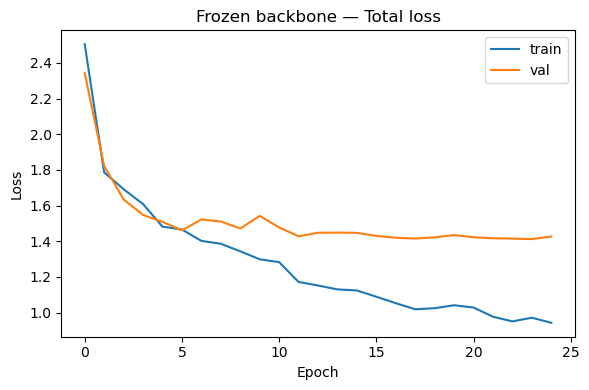

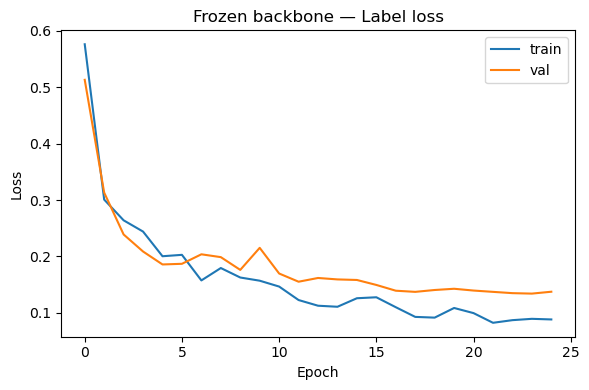

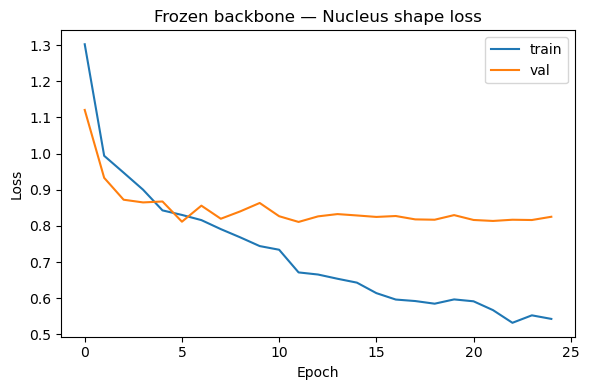

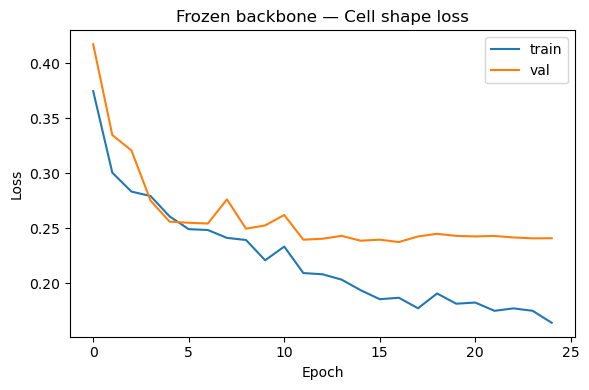

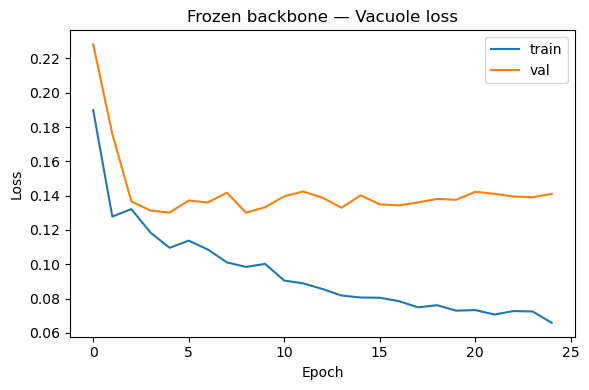

In [34]:
# For the frozen-backbone baseline:
plot_loss_curves(hist_base, title_prefix="Frozen backbone")

In [27]:
# =========================
# 7) Hyperparameter tuning on dropout
# =========================
dropout_grid = [0.2, 0.35, 0.5]
results = []

for dr in dropout_grid:
    print("\n"+"="*60)
    print(f"Trial: dropout={dr}")
    print("="*60)
    m = build_model(dropout_rate=dr)
    cb = MultiHeadValMetrics(val_ds)  # fresh callback per trial
    hist = m.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[cb, plateau_cb, early_cb],
        verbose=1
    )
    best_overall = max(hist.history.get("val_overall", [0.0]))
    results.append({"dropout": dr, "best_val_overall": best_overall, "history": hist, "model": m})

# Pick best by val_overall
best_trial = max(results, key=lambda r: r["best_val_overall"])
print(f"\nBest dropout: {best_trial['dropout']}  with val_overall={best_trial['best_val_overall']:.3f}")
best_model = best_trial["model"]
best_hist  = best_trial["history"]



Trial: dropout=0.2
Epoch 1/40


2025-08-26 04:19:48.327478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2348 of 8192
2025-08-26 04:19:53.149194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 2.3834 - label_loss: 0.5343 - nucleus_loss: 1.2411 - cell_loss: 0.3714 - vacuole_loss: 0.1753

2025-08-26 04:20:21.161071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Val] F1(label)=0.884 | F1(nucleus)=0.553 | F1(cell)=0.641 | F1(vacuole)=0.532 | overall=0.652
110/110 [==============================] - 62s 338ms/step - loss: 2.3824 - label_loss: 0.5345 - nucleus_loss: 1.2401 - cell_loss: 0.3710 - vacuole_loss: 0.1755 - val_loss: 2.4905 - val_label_loss: 0.5939 - val_nucleus_loss: 1.1815 - val_cell_loss: 0.3859 - val_vacuole_loss: 0.2668 - val_label_macro_f1: 0.8838 - val_nucleus_macro_f1: 0.5532 - val_cell_f1: 0.6406 - val_vacuole_f1: 0.5316 - val_overall: 0.6523 - lr: 0.0010
Epoch 2/40


2025-08-26 04:20:40.434989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2348 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.7545 - label_loss: 0.2925 - nucleus_loss: 0.8506 - cell_loss: 0.3643 - vacuole_loss: 0.1847  

2025-08-26 04:20:45.274795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.7682 - label_loss: 0.2886 - nucleus_loss: 0.9777 - cell_loss: 0.3045 - vacuole_loss: 0.1342 - val_loss: 1.8065 - val_label_loss: 0.3221 - val_nucleus_loss: 0.9430 - val_cell_loss: 0.3111 - val_vacuole_loss: 0.1661 - val_label_macro_f1: 0.9204 - val_nucleus_macro_f1: 0.6126 - val_cell_f1: 0.6897 - val_vacuole_f1: 0.5682 - val_overall: 0.6977 - lr: 0.0010


2025-08-26 04:21:01.194855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/40


2025-08-26 04:21:21.383640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2204 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2736 - label_loss: 0.1703 - nucleus_loss: 0.7219 - cell_loss: 0.2082 - vacuole_loss: 0.1090  

2025-08-26 04:21:27.279773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 145ms/step - loss: 1.5815 - label_loss: 0.2382 - nucleus_loss: 0.8812 - cell_loss: 0.2764 - vacuole_loss: 0.1205 - val_loss: 1.5643 - val_label_loss: 0.2384 - val_nucleus_loss: 0.8583 - val_cell_loss: 0.2594 - val_vacuole_loss: 0.1423 - val_label_macro_f1: 0.9201 - val_nucleus_macro_f1: 0.6345 - val_cell_f1: 0.6565 - val_vacuole_f1: 0.6000 - val_overall: 0.7028 - lr: 0.0010
Epoch 4/40


2025-08-26 04:21:43.166256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:21:53.239568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2352 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.5128 - label_loss: 0.1815 - nucleus_loss: 0.9100 - cell_loss: 0.3084 - vacuole_loss: 0.0468   

2025-08-26 04:21:58.036329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4650 - label_loss: 0.1918 - nucleus_loss: 0.8363 - cell_loss: 0.2571 - vacuole_loss: 0.1129 - val_loss: 1.5345 - val_label_loss: 0.2051 - val_nucleus_loss: 0.8635 - val_cell_loss: 0.2653 - val_vacuole_loss: 0.1330 - val_label_macro_f1: 0.9261 - val_nucleus_macro_f1: 0.6459 - val_cell_f1: 0.6833 - val_vacuole_f1: 0.6437 - val_overall: 0.7247 - lr: 0.0010
Epoch 5/40


2025-08-26 04:22:14.007483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:22:24.088603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2346 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2547 - label_loss: 0.0878 - nucleus_loss: 0.7793 - cell_loss: 0.2713 - vacuole_loss: 0.0486  

2025-08-26 04:22:28.935114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4113 - label_loss: 0.1847 - nucleus_loss: 0.8083 - cell_loss: 0.2403 - vacuole_loss: 0.1095 - val_loss: 1.4637 - val_label_loss: 0.1891 - val_nucleus_loss: 0.8238 - val_cell_loss: 0.2380 - val_vacuole_loss: 0.1432 - val_label_macro_f1: 0.9333 - val_nucleus_macro_f1: 0.6925 - val_cell_f1: 0.7429 - val_vacuole_f1: 0.6526 - val_overall: 0.7553 - lr: 0.0010
Epoch 6/40


2025-08-26 04:22:44.919703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:22:55.002233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2349 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1275 - label_loss: 0.0789 - nucleus_loss: 0.7027 - cell_loss: 0.1736 - vacuole_loss: 0.1029  

2025-08-26 04:22:59.831400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.3729 - label_loss: 0.1735 - nucleus_loss: 0.7963 - cell_loss: 0.2335 - vacuole_loss: 0.0992 - val_loss: 1.5282 - val_label_loss: 0.2009 - val_nucleus_loss: 0.8628 - val_cell_loss: 0.2520 - val_vacuole_loss: 0.1410 - val_label_macro_f1: 0.9219 - val_nucleus_macro_f1: 0.6344 - val_cell_f1: 0.6992 - val_vacuole_f1: 0.5479 - val_overall: 0.7009 - lr: 0.0010
Epoch 7/40


2025-08-26 04:23:15.779875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:23:25.804743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2346 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.7683 - label_loss: 0.1293 - nucleus_loss: 0.8901 - cell_loss: 0.4318 - vacuole_loss: 0.2457   

2025-08-26 04:23:30.653431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 145ms/step - loss: 1.3159 - label_loss: 0.1544 - nucleus_loss: 0.7541 - cell_loss: 0.2330 - vacuole_loss: 0.1022 - val_loss: 1.5004 - val_label_loss: 0.1867 - val_nucleus_loss: 0.8275 - val_cell_loss: 0.2705 - val_vacuole_loss: 0.1424 - val_label_macro_f1: 0.9279 - val_nucleus_macro_f1: 0.6656 - val_cell_f1: 0.7092 - val_vacuole_f1: 0.6364 - val_overall: 0.7348 - lr: 0.0010
Epoch 8/40


2025-08-26 04:23:46.542941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:23:56.574209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2355 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.5735 - label_loss: 0.3127 - nucleus_loss: 0.8393 - cell_loss: 0.3143 - vacuole_loss: 0.0340  

2025-08-26 04:24:01.466151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.3127 - label_loss: 0.1738 - nucleus_loss: 0.7340 - cell_loss: 0.2285 - vacuole_loss: 0.1022[Val] F1(label)=0.943 | F1(nucleus)=0.677 | F1(cell)=0.725 | F1(vacuole)=0.602 | overall=0.737

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 [==============================] - 31s 146ms/step - loss: 1.3126 - label_loss: 0.1733 - nucleus_loss: 0.7340 - cell_loss: 0.2292 - vacuole_loss: 0.1019 - val_loss: 1.4467 - val_label_loss: 0.1424 - val_nucleus_loss: 0.8254 - val_cell_loss: 0.2623 - val_vacuole_loss: 0.1414 - val_label_macro_f1: 0.9431 - val_nucleus_macro_f1: 0.6767 - val_cell_f1: 0.7246 - val_vacuole_f1: 0.6024 - val_overall: 0.7367 - lr: 0.0010
Epoch 9/40


2025-08-26 04:24:17.478585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:24:27.504158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2094 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.2180 - label_loss: 0.1224 - nucleus_loss: 0.6706 - cell_loss: 0.2097 - vacuole_loss: 0.1400   

2025-08-26 04:24:33.410314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 146ms/step - loss: 1.1867 - label_loss: 0.1390 - nucleus_loss: 0.6800 - cell_loss: 0.2018 - vacuole_loss: 0.0903 - val_loss: 1.3724 - val_label_loss: 0.1351 - val_nucleus_loss: 0.7809 - val_cell_loss: 0.2418 - val_vacuole_loss: 0.1388 - val_label_macro_f1: 0.9504 - val_nucleus_macro_f1: 0.6839 - val_cell_f1: 0.7200 - val_vacuole_f1: 0.6279 - val_overall: 0.7456 - lr: 5.0000e-04
Epoch 10/40


2025-08-26 04:24:49.380941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:24:59.405148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2357 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.0393 - label_loss: 0.1276 - nucleus_loss: 0.6120 - cell_loss: 0.1548 - vacuole_loss: 0.0692   

2025-08-26 04:25:04.267314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.1391 - label_loss: 0.1217 - nucleus_loss: 0.6482 - cell_loss: 0.2000 - vacuole_loss: 0.0932 - val_loss: 1.4364 - val_label_loss: 0.1572 - val_nucleus_loss: 0.8094 - val_cell_loss: 0.2532 - val_vacuole_loss: 0.1406 - val_label_macro_f1: 0.9406 - val_nucleus_macro_f1: 0.6834 - val_cell_f1: 0.6813 - val_vacuole_f1: 0.5783 - val_overall: 0.7209 - lr: 5.0000e-04
Epoch 11/40


2025-08-26 04:25:20.216076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:25:30.239966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2348 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.4122 - label_loss: 0.1322 - nucleus_loss: 0.7181 - cell_loss: 0.2680 - vacuole_loss: 0.2178  

2025-08-26 04:25:35.050479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.1034 - label_loss: 0.1002 - nucleus_loss: 0.6382 - cell_loss: 0.2040 - vacuole_loss: 0.0846[Val] F1(label)=0.954 | F1(nucleus)=0.686 | F1(cell)=0.736 | F1(vacuole)=0.587 | overall=0.741

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 [==============================] - 31s 146ms/step - loss: 1.1079 - label_loss: 0.1008 - nucleus_loss: 0.6398 - cell_loss: 0.2064 - vacuole_loss: 0.0845 - val_loss: 1.4323 - val_label_loss: 0.1357 - val_nucleus_loss: 0.8226 - val_cell_loss: 0.2519 - val_vacuole_loss: 0.1454 - val_label_macro_f1: 0.9544 - val_nucleus_macro_f1: 0.6862 - val_cell_f1: 0.7356 - val_vacuole_f1: 0.5867 - val_overall: 0.7407 - lr: 5.0000e-04
Epoch 12/40


2025-08-26 04:25:51.025392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:26:01.053853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2360 of 8192


  2/110 [..............................] - ETA: 9s - loss: 0.9662 - label_loss: 0.0616 - nucleus_loss: 0.6340 - cell_loss: 0.1313 - vacuole_loss: 0.0627   

2025-08-26 04:26:05.908874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.0770 - label_loss: 0.1094 - nucleus_loss: 0.6234 - cell_loss: 0.1851 - vacuole_loss: 0.0823 - val_loss: 1.4049 - val_label_loss: 0.1314 - val_nucleus_loss: 0.8089 - val_cell_loss: 0.2496 - val_vacuole_loss: 0.1382 - val_label_macro_f1: 0.9515 - val_nucleus_macro_f1: 0.7044 - val_cell_f1: 0.7008 - val_vacuole_f1: 0.5714 - val_overall: 0.7320 - lr: 2.5000e-04

Trial: dropout=0.35


2025-08-26 04:26:21.911869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/40


2025-08-26 04:26:43.235551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2340 of 8192
2025-08-26 04:26:48.119680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 54s 260ms/step - loss: 2.5209 - label_loss: 0.5926 - nucleus_loss: 1.2885 - cell_loss: 0.3958 - vacuole_loss: 0.1827 - val_loss: 2.4084 - val_label_loss: 0.5639 - val_nucleus_loss: 1.1468 - val_cell_loss: 0.4219 - val_vacuole_loss: 0.2134 - val_label_macro_f1: 0.8782 - val_nucleus_macro_f1: 0.5539 - val_cell_f1: 0.6169 - val_vacuole_f1: 0.4928 - val_overall: 0.6354 - lr: 0.0010
Epoch 2/40


2025-08-26 04:27:16.746741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:27:26.868406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2060 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.9369 - label_loss: 0.3576 - nucleus_loss: 1.1039 - cell_loss: 0.3301 - vacuole_loss: 0.0831   

2025-08-26 04:27:32.920975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 147ms/step - loss: 1.8444 - label_loss: 0.3180 - nucleus_loss: 1.0017 - cell_loss: 0.3178 - vacuole_loss: 0.1438 - val_loss: 1.8820 - val_label_loss: 0.3328 - val_nucleus_loss: 0.9775 - val_cell_loss: 0.3342 - val_vacuole_loss: 0.1736 - val_label_macro_f1: 0.9009 - val_nucleus_macro_f1: 0.5678 - val_cell_f1: 0.6923 - val_vacuole_f1: 0.5750 - val_overall: 0.6840 - lr: 0.0010
Epoch 3/40


2025-08-26 04:27:48.956815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:27:59.028540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2337 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.9341 - label_loss: 0.4619 - nucleus_loss: 1.0338 - cell_loss: 0.2902 - vacuole_loss: 0.0841  

2025-08-26 04:28:04.012439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.7420 - label_loss: 0.2824 - nucleus_loss: 0.9711 - cell_loss: 0.2932 - vacuole_loss: 0.1304 - val_loss: 1.6309 - val_label_loss: 0.2432 - val_nucleus_loss: 0.8891 - val_cell_loss: 0.2931 - val_vacuole_loss: 0.1397 - val_label_macro_f1: 0.9126 - val_nucleus_macro_f1: 0.5836 - val_cell_f1: 0.7114 - val_vacuole_f1: 0.5823 - val_overall: 0.6975 - lr: 0.0010
Epoch 4/40


2025-08-26 04:28:20.043096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:28:30.120530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2322 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.7176 - label_loss: 0.2742 - nucleus_loss: 0.8324 - cell_loss: 0.3481 - vacuole_loss: 0.1973  

2025-08-26 04:28:35.127228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 148ms/step - loss: 1.6278 - label_loss: 0.2580 - nucleus_loss: 0.8930 - cell_loss: 0.2847 - vacuole_loss: 0.1255 - val_loss: 1.5022 - val_label_loss: 0.1947 - val_nucleus_loss: 0.8373 - val_cell_loss: 0.2702 - val_vacuole_loss: 0.1326 - val_label_macro_f1: 0.9331 - val_nucleus_macro_f1: 0.6501 - val_cell_f1: 0.6920 - val_vacuole_f1: 0.5405 - val_overall: 0.7040 - lr: 0.0010
Epoch 5/40


2025-08-26 04:28:51.230411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:29:01.321903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2319 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1937 - label_loss: 0.0524 - nucleus_loss: 0.6190 - cell_loss: 0.2431 - vacuole_loss: 0.2119  

2025-08-26 04:29:06.353656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.5568 - label_loss: 0.2238 - nucleus_loss: 0.8788 - cell_loss: 0.2654 - vacuole_loss: 0.1206 - val_loss: 1.4889 - val_label_loss: 0.1831 - val_nucleus_loss: 0.8333 - val_cell_loss: 0.2696 - val_vacuole_loss: 0.1340 - val_label_macro_f1: 0.9415 - val_nucleus_macro_f1: 0.6352 - val_cell_f1: 0.6947 - val_vacuole_f1: 0.6353 - val_overall: 0.7267 - lr: 0.0010
Epoch 6/40


2025-08-26 04:29:22.382875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:29:32.457442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2334 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.4329 - label_loss: 0.1449 - nucleus_loss: 0.8702 - cell_loss: 0.2103 - vacuole_loss: 0.1385   

2025-08-26 04:29:37.483132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4827 - label_loss: 0.2050 - nucleus_loss: 0.8365 - cell_loss: 0.2572 - vacuole_loss: 0.1142 - val_loss: 1.5008 - val_label_loss: 0.1981 - val_nucleus_loss: 0.8509 - val_cell_loss: 0.2493 - val_vacuole_loss: 0.1318 - val_label_macro_f1: 0.9273 - val_nucleus_macro_f1: 0.6081 - val_cell_f1: 0.7306 - val_vacuole_f1: 0.5823 - val_overall: 0.7121 - lr: 0.0010
Epoch 7/40


2025-08-26 04:29:53.530371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:30:03.557676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2313 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.4202 - label_loss: 0.2249 - nucleus_loss: 0.5348 - cell_loss: 0.2898 - vacuole_loss: 0.3001   

2025-08-26 04:30:08.593544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 149ms/step - loss: 1.4117 - label_loss: 0.1643 - nucleus_loss: 0.8067 - cell_loss: 0.2554 - vacuole_loss: 0.1139 - val_loss: 1.4990 - val_label_loss: 0.1813 - val_nucleus_loss: 0.8604 - val_cell_loss: 0.2555 - val_vacuole_loss: 0.1295 - val_label_macro_f1: 0.9306 - val_nucleus_macro_f1: 0.6184 - val_cell_f1: 0.7045 - val_vacuole_f1: 0.6420 - val_overall: 0.7239 - lr: 0.0010
Epoch 8/40


2025-08-26 04:30:24.863491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:30:34.889957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2310 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.5908 - label_loss: 0.1503 - nucleus_loss: 0.8369 - cell_loss: 0.4069 - vacuole_loss: 0.1245   

2025-08-26 04:30:39.988510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 148ms/step - loss: 1.4744 - label_loss: 0.2145 - nucleus_loss: 0.8204 - cell_loss: 0.2559 - vacuole_loss: 0.1105 - val_loss: 1.4340 - val_label_loss: 0.1723 - val_nucleus_loss: 0.8159 - val_cell_loss: 0.2449 - val_vacuole_loss: 0.1267 - val_label_macro_f1: 0.9346 - val_nucleus_macro_f1: 0.6302 - val_cell_f1: 0.7266 - val_vacuole_f1: 0.6506 - val_overall: 0.7355 - lr: 0.0010
Epoch 9/40


2025-08-26 04:30:56.103054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:31:06.179880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2274 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2001 - label_loss: 0.0633 - nucleus_loss: 0.8034 - cell_loss: 0.1623 - vacuole_loss: 0.0970  

2025-08-26 04:31:11.451480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.3828 - label_loss: 0.1727 - nucleus_loss: 0.7885 - cell_loss: 0.2364 - vacuole_loss: 0.1102 - val_loss: 1.4501 - val_label_loss: 0.1813 - val_nucleus_loss: 0.8223 - val_cell_loss: 0.2447 - val_vacuole_loss: 0.1260 - val_label_macro_f1: 0.9341 - val_nucleus_macro_f1: 0.6711 - val_cell_f1: 0.7391 - val_vacuole_f1: 0.6588 - val_overall: 0.7508 - lr: 0.0010
Epoch 10/40


2025-08-26 04:31:27.534097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:31:37.609107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2305 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2441 - label_loss: 0.0329 - nucleus_loss: 0.7728 - cell_loss: 0.2205 - vacuole_loss: 0.1421  

2025-08-26 04:31:42.677041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.3689 - label_loss: 0.1675 - nucleus_loss: 0.7757 - cell_loss: 0.2416 - vacuole_loss: 0.1074 - val_loss: 1.5300 - val_label_loss: 0.1982 - val_nucleus_loss: 0.8959 - val_cell_loss: 0.2336 - val_vacuole_loss: 0.1248 - val_label_macro_f1: 0.9264 - val_nucleus_macro_f1: 0.6206 - val_cell_f1: 0.7138 - val_vacuole_f1: 0.6500 - val_overall: 0.7277 - lr: 0.0010
Epoch 11/40


2025-08-26 04:31:58.733633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:32:08.757647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2275 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.6918 - label_loss: 0.2907 - nucleus_loss: 0.9136 - cell_loss: 0.2821 - vacuole_loss: 0.1278  

2025-08-26 04:32:14.087583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 148ms/step - loss: 1.3609 - label_loss: 0.1781 - nucleus_loss: 0.7779 - cell_loss: 0.2258 - vacuole_loss: 0.1007 - val_loss: 1.4136 - val_label_loss: 0.1578 - val_nucleus_loss: 0.8029 - val_cell_loss: 0.2477 - val_vacuole_loss: 0.1260 - val_label_macro_f1: 0.9384 - val_nucleus_macro_f1: 0.6530 - val_cell_f1: 0.7111 - val_vacuole_f1: 0.6517 - val_overall: 0.7386 - lr: 0.0010
Epoch 12/40


2025-08-26 04:32:30.318924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:32:40.349481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2130 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.0634 - label_loss: 0.2153 - nucleus_loss: 0.5924 - cell_loss: 0.1299 - vacuole_loss: 0.0465  

2025-08-26 04:32:46.716637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.2894 - label_loss: 0.1469 - nucleus_loss: 0.7291 - cell_loss: 0.2345 - vacuole_loss: 0.0987[Val] F1(label)=0.949 | F1(nucleus)=0.644 | F1(cell)=0.732 | F1(vacuole)=0.617 | overall=0.736

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 [==============================] - 33s 148ms/step - loss: 1.2914 - label_loss: 0.1484 - nucleus_loss: 0.7296 - cell_loss: 0.2348 - vacuole_loss: 0.0984 - val_loss: 1.4135 - val_label_loss: 0.1490 - val_nucleus_loss: 0.8142 - val_cell_loss: 0.2381 - val_vacuole_loss: 0.1311 - val_label_macro_f1: 0.9486 - val_nucleus_macro_f1: 0.6443 - val_cell_f1: 0.7319 - val_vacuole_f1: 0.6173 - val_overall: 0.7355 - lr: 0.0010
Epoch 13/40


2025-08-26 04:33:02.951958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:33:12.981833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2135 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1931 - label_loss: 0.1093 - nucleus_loss: 0.6711 - cell_loss: 0.3032 - vacuole_loss: 0.0285  

2025-08-26 04:33:19.255377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 148ms/step - loss: 1.2089 - label_loss: 0.1278 - nucleus_loss: 0.6948 - cell_loss: 0.2046 - vacuole_loss: 0.1004 - val_loss: 1.3998 - val_label_loss: 0.1457 - val_nucleus_loss: 0.8098 - val_cell_loss: 0.2363 - val_vacuole_loss: 0.1265 - val_label_macro_f1: 0.9460 - val_nucleus_macro_f1: 0.6498 - val_cell_f1: 0.7376 - val_vacuole_f1: 0.6024 - val_overall: 0.7340 - lr: 5.0000e-04
Epoch 14/40


2025-08-26 04:33:35.418836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:33:45.444259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2220 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.1684 - label_loss: 0.1828 - nucleus_loss: 0.6772 - cell_loss: 0.1615 - vacuole_loss: 0.0654  

2025-08-26 04:33:51.126147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 148ms/step - loss: 1.1914 - label_loss: 0.1202 - nucleus_loss: 0.6943 - cell_loss: 0.2067 - vacuole_loss: 0.0886 - val_loss: 1.3733 - val_label_loss: 0.1389 - val_nucleus_loss: 0.7883 - val_cell_loss: 0.2324 - val_vacuole_loss: 0.1318 - val_label_macro_f1: 0.9545 - val_nucleus_macro_f1: 0.6866 - val_cell_f1: 0.7463 - val_vacuole_f1: 0.5789 - val_overall: 0.7416 - lr: 5.0000e-04
Epoch 15/40


2025-08-26 04:34:07.297016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:34:17.321976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2201 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.0853 - label_loss: 0.1007 - nucleus_loss: 0.4929 - cell_loss: 0.2552 - vacuole_loss: 0.1547  

2025-08-26 04:34:23.140856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.1681 - label_loss: 0.1235 - nucleus_loss: 0.6690 - cell_loss: 0.2019 - vacuole_loss: 0.0918[Val] F1(label)=0.958 | F1(nucleus)=0.652 | F1(cell)=0.723 | F1(vacuole)=0.605 | overall=0.734

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 [==============================] - 32s 147ms/step - loss: 1.1665 - label_loss: 0.1232 - nucleus_loss: 0.6679 - cell_loss: 0.2020 - vacuole_loss: 0.0915 - val_loss: 1.3738 - val_label_loss: 0.1310 - val_nucleus_loss: 0.8011 - val_cell_loss: 0.2298 - val_vacuole_loss: 0.1298 - val_label_macro_f1: 0.9576 - val_nucleus_macro_f1: 0.6518 - val_cell_f1: 0.7232 - val_vacuole_f1: 0.6053 - val_overall: 0.7345 - lr: 5.0000e-04


2025-08-26 04:34:39.276544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/40


2025-08-26 04:34:58.288116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2212 of 8192


  2/110 [..............................] - ETA: 10s - loss: 0.9091 - label_loss: 0.1326 - nucleus_loss: 0.5756 - cell_loss: 0.0799 - vacuole_loss: 0.0389  

2025-08-26 04:35:04.099290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 147ms/step - loss: 1.1231 - label_loss: 0.1113 - nucleus_loss: 0.6385 - cell_loss: 0.2027 - vacuole_loss: 0.0884 - val_loss: 1.3531 - val_label_loss: 0.1273 - val_nucleus_loss: 0.7870 - val_cell_loss: 0.2286 - val_vacuole_loss: 0.1280 - val_label_macro_f1: 0.9536 - val_nucleus_macro_f1: 0.6723 - val_cell_f1: 0.7454 - val_vacuole_f1: 0.6098 - val_overall: 0.7453 - lr: 2.5000e-04

Trial: dropout=0.5


2025-08-26 04:35:20.236664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/40


2025-08-26 04:35:41.592423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2259 of 8192
2025-08-26 04:35:47.014645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 55s 262ms/step - loss: 2.7299 - label_loss: 0.6783 - nucleus_loss: 1.3764 - cell_loss: 0.3992 - vacuole_loss: 0.2150 - val_loss: 2.4301 - val_label_loss: 0.5789 - val_nucleus_loss: 1.1764 - val_cell_loss: 0.3919 - val_vacuole_loss: 0.2209 - val_label_macro_f1: 0.8597 - val_nucleus_macro_f1: 0.5594 - val_cell_f1: 0.6245 - val_vacuole_f1: 0.5067 - val_overall: 0.6376 - lr: 0.0010
Epoch 2/40


2025-08-26 04:36:15.911374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:36:26.045047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2022 of 8192


  2/110 [..............................] - ETA: 10s - loss: 2.1579 - label_loss: 0.5811 - nucleus_loss: 1.1117 - cell_loss: 0.2439 - vacuole_loss: 0.1592  

2025-08-26 04:36:32.295617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 147ms/step - loss: 2.0467 - label_loss: 0.3849 - nucleus_loss: 1.0978 - cell_loss: 0.3467 - vacuole_loss: 0.1544 - val_loss: 1.8135 - val_label_loss: 0.3072 - val_nucleus_loss: 0.9405 - val_cell_loss: 0.3384 - val_vacuole_loss: 0.1637 - val_label_macro_f1: 0.9145 - val_nucleus_macro_f1: 0.6171 - val_cell_f1: 0.6780 - val_vacuole_f1: 0.6316 - val_overall: 0.7103 - lr: 0.0010
Epoch 3/40


2025-08-26 04:36:48.323031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:36:58.399941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2329 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.9018 - label_loss: 0.4306 - nucleus_loss: 1.0310 - cell_loss: 0.2901 - vacuole_loss: 0.0865  

2025-08-26 04:37:03.393875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.8706 - label_loss: 0.3205 - nucleus_loss: 1.0297 - cell_loss: 0.3105 - vacuole_loss: 0.1454 - val_loss: 1.6311 - val_label_loss: 0.2552 - val_nucleus_loss: 0.8902 - val_cell_loss: 0.2755 - val_vacuole_loss: 0.1451 - val_label_macro_f1: 0.9235 - val_nucleus_macro_f1: 0.6256 - val_cell_f1: 0.6667 - val_vacuole_f1: 0.6000 - val_overall: 0.7039 - lr: 0.0010
Epoch 4/40


2025-08-26 04:37:19.360098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:37:29.383315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2349 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.8531 - label_loss: 0.4493 - nucleus_loss: 0.9604 - cell_loss: 0.3249 - vacuole_loss: 0.0535   

2025-08-26 04:37:34.216267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.7395 - label_loss: 0.2845 - nucleus_loss: 0.9547 - cell_loss: 0.3040 - vacuole_loss: 0.1304 - val_loss: 1.5018 - val_label_loss: 0.1960 - val_nucleus_loss: 0.8399 - val_cell_loss: 0.2690 - val_vacuole_loss: 0.1303 - val_label_macro_f1: 0.9328 - val_nucleus_macro_f1: 0.6404 - val_cell_f1: 0.6531 - val_vacuole_f1: 0.6067 - val_overall: 0.7083 - lr: 0.0010


2025-08-26 04:37:50.165277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/40


2025-08-26 04:38:10.337015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2332 of 8192


  2/110 [..............................] - ETA: 10s - loss: 2.1374 - label_loss: 0.4124 - nucleus_loss: 1.2326 - cell_loss: 0.2761 - vacuole_loss: 0.1497  

2025-08-26 04:38:15.334949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.6610 - label_loss: 0.2337 - nucleus_loss: 0.9421 - cell_loss: 0.2910 - vacuole_loss: 0.1269[Val] F1(label)=0.929 | F1(nucleus)=0.656 | F1(cell)=0.682 | F1(vacuole)=0.575 | overall=0.710

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 [==============================] - 32s 151ms/step - loss: 1.6617 - label_loss: 0.2339 - nucleus_loss: 0.9425 - cell_loss: 0.2915 - vacuole_loss: 0.1266 - val_loss: 1.4902 - val_label_loss: 0.1794 - val_nucleus_loss: 0.8450 - val_cell_loss: 0.2639 - val_vacuole_loss: 0.1340 - val_label_macro_f1: 0.9288 - val_nucleus_macro_f1: 0.6557 - val_cell_f1: 0.6820 - val_vacuole_f1: 0.5747 - val_overall: 0.7103 - lr: 0.0010
Epoch 6/40


2025-08-26 04:38:31.775876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:38:41.851521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2351 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2784 - label_loss: 0.1076 - nucleus_loss: 0.7953 - cell_loss: 0.2545 - vacuole_loss: 0.0531  

2025-08-26 04:38:46.670482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.5540 - label_loss: 0.2094 - nucleus_loss: 0.8773 - cell_loss: 0.2676 - vacuole_loss: 0.1317 - val_loss: 1.4372 - val_label_loss: 0.1701 - val_nucleus_loss: 0.8100 - val_cell_loss: 0.2531 - val_vacuole_loss: 0.1358 - val_label_macro_f1: 0.9358 - val_nucleus_macro_f1: 0.6513 - val_cell_f1: 0.7059 - val_vacuole_f1: 0.5679 - val_overall: 0.7152 - lr: 5.0000e-04


2025-08-26 04:39:02.771638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/40


2025-08-26 04:39:22.805735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2122 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.3325 - label_loss: 0.2278 - nucleus_loss: 0.7741 - cell_loss: 0.1834 - vacuole_loss: 0.0790   

2025-08-26 04:39:28.692816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 32s 147ms/step - loss: 1.5248 - label_loss: 0.2263 - nucleus_loss: 0.8557 - cell_loss: 0.2600 - vacuole_loss: 0.1146 - val_loss: 1.4279 - val_label_loss: 0.1632 - val_nucleus_loss: 0.8113 - val_cell_loss: 0.2516 - val_vacuole_loss: 0.1334 - val_label_macro_f1: 0.9376 - val_nucleus_macro_f1: 0.6497 - val_cell_f1: 0.7029 - val_vacuole_f1: 0.6207 - val_overall: 0.7277 - lr: 5.0000e-04
Epoch 8/40


2025-08-26 04:39:44.757491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:39:54.834629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2356 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.3273 - label_loss: 0.1534 - nucleus_loss: 0.8601 - cell_loss: 0.1886 - vacuole_loss: 0.0569  

2025-08-26 04:39:59.619628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 147ms/step - loss: 1.4985 - label_loss: 0.2143 - nucleus_loss: 0.8404 - cell_loss: 0.2623 - vacuole_loss: 0.1131 - val_loss: 1.4087 - val_label_loss: 0.1602 - val_nucleus_loss: 0.7959 - val_cell_loss: 0.2509 - val_vacuole_loss: 0.1330 - val_label_macro_f1: 0.9393 - val_nucleus_macro_f1: 0.6782 - val_cell_f1: 0.7138 - val_vacuole_f1: 0.6076 - val_overall: 0.7347 - lr: 5.0000e-04
Epoch 9/40


2025-08-26 04:40:15.664484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:40:25.738333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2328 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.6152 - label_loss: 0.1650 - nucleus_loss: 0.8661 - cell_loss: 0.3883 - vacuole_loss: 0.1272   

2025-08-26 04:40:30.654275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4542 - label_loss: 0.2042 - nucleus_loss: 0.8220 - cell_loss: 0.2508 - vacuole_loss: 0.1083 - val_loss: 1.4099 - val_label_loss: 0.1575 - val_nucleus_loss: 0.7954 - val_cell_loss: 0.2526 - val_vacuole_loss: 0.1353 - val_label_macro_f1: 0.9382 - val_nucleus_macro_f1: 0.6443 - val_cell_f1: 0.7333 - val_vacuole_f1: 0.5682 - val_overall: 0.7210 - lr: 5.0000e-04
Epoch 10/40


2025-08-26 04:40:46.658679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:40:56.683053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2349 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.1325 - label_loss: 0.1039 - nucleus_loss: 0.6736 - cell_loss: 0.2070 - vacuole_loss: 0.0790   

2025-08-26 04:41:01.490346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.4424 - label_loss: 0.1864 - nucleus_loss: 0.8134 - cell_loss: 0.2654 - vacuole_loss: 0.1080 - val_loss: 1.4174 - val_label_loss: 0.1530 - val_nucleus_loss: 0.8073 - val_cell_loss: 0.2518 - val_vacuole_loss: 0.1360 - val_label_macro_f1: 0.9387 - val_nucleus_macro_f1: 0.6439 - val_cell_f1: 0.7228 - val_vacuole_f1: 0.5823 - val_overall: 0.7219 - lr: 5.0000e-04
Epoch 11/40


2025-08-26 04:41:17.527882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:41:27.553066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2357 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.3184 - label_loss: 0.2133 - nucleus_loss: 0.7092 - cell_loss: 0.2056 - vacuole_loss: 0.1208  

2025-08-26 04:41:32.591563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.4286 - label_loss: 0.1797 - nucleus_loss: 0.8172 - cell_loss: 0.2476 - vacuole_loss: 0.1145

2025-08-26 04:41:48.600447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Val] F1(label)=0.949 | F1(nucleus)=0.659 | F1(cell)=0.719 | F1(vacuole)=0.593 | overall=0.730

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 [==============================] - 32s 159ms/step - loss: 1.4300 - label_loss: 0.1803 - nucleus_loss: 0.8175 - cell_loss: 0.2476 - vacuole_loss: 0.1150 - val_loss: 1.3856 - val_label_loss: 0.1407 - val_nucleus_loss: 0.7980 - val_cell_loss: 0.2439 - val_vacuole_loss: 0.1334 - val_label_macro_f1: 0.9490 - val_nucleus_macro_f1: 0.6593 - val_cell_f1: 0.7185 - val_vacuole_f1: 0.5926 - val_overall: 0.7298 - lr: 5.0000e-04
Epoch 12/40


2025-08-26 04:41:59.999705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2355 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.6697 - label_loss: 0.3833 - nucleus_loss: 0.8205 - cell_loss: 0.2873 - vacuole_loss: 0.1090  

2025-08-26 04:42:04.892740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 148ms/step - loss: 1.3750 - label_loss: 0.1795 - nucleus_loss: 0.7787 - cell_loss: 0.2461 - vacuole_loss: 0.1010 - val_loss: 1.3791 - val_label_loss: 0.1417 - val_nucleus_loss: 0.7926 - val_cell_loss: 0.2437 - val_vacuole_loss: 0.1314 - val_label_macro_f1: 0.9479 - val_nucleus_macro_f1: 0.6661 - val_cell_f1: 0.7200 - val_vacuole_f1: 0.6265 - val_overall: 0.7401 - lr: 2.5000e-04
Epoch 13/40


2025-08-26 04:42:21.028555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:42:31.112103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2269 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.2483 - label_loss: 0.1452 - nucleus_loss: 0.7823 - cell_loss: 0.1737 - vacuole_loss: 0.0773  

2025-08-26 04:42:36.337850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.3549 - label_loss: 0.1652 - nucleus_loss: 0.7700 - cell_loss: 0.2447 - vacuole_loss: 0.1053 - val_loss: 1.3795 - val_label_loss: 0.1430 - val_nucleus_loss: 0.7869 - val_cell_loss: 0.2458 - val_vacuole_loss: 0.1339 - val_label_macro_f1: 0.9447 - val_nucleus_macro_f1: 0.6770 - val_cell_f1: 0.7252 - val_vacuole_f1: 0.5753 - val_overall: 0.7306 - lr: 2.5000e-04
Epoch 14/40


2025-08-26 04:42:52.331775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:43:02.358064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2339 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.4566 - label_loss: 0.1398 - nucleus_loss: 0.9073 - cell_loss: 0.2007 - vacuole_loss: 0.1391   

2025-08-26 04:43:07.222312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.3193 - label_loss: 0.1546 - nucleus_loss: 0.7516 - cell_loss: 0.2403 - vacuole_loss: 0.1030 - val_loss: 1.3671 - val_label_loss: 0.1358 - val_nucleus_loss: 0.7849 - val_cell_loss: 0.2458 - val_vacuole_loss: 0.1308 - val_label_macro_f1: 0.9445 - val_nucleus_macro_f1: 0.6810 - val_cell_f1: 0.7209 - val_vacuole_f1: 0.5823 - val_overall: 0.7322 - lr: 2.5000e-04
Epoch 15/40


2025-08-26 04:43:23.234832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:43:33.258528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2353 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.3278 - label_loss: 0.2106 - nucleus_loss: 0.7138 - cell_loss: 0.1875 - vacuole_loss: 0.1461  

2025-08-26 04:43:38.067589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.3051 - label_loss: 0.1501 - nucleus_loss: 0.7516 - cell_loss: 0.2328 - vacuole_loss: 0.1007[Val] F1(label)=0.942 | F1(nucleus)=0.674 | F1(cell)=0.721 | F1(vacuole)=0.608 | overall=0.736

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
110/110 [==============================] - 31s 147ms/step - loss: 1.3051 - label_loss: 0.1504 - nucleus_loss: 0.7517 - cell_loss: 0.2326 - vacuole_loss: 0.1005 - val_loss: 1.3612 - val_label_loss: 0.1341 - val_nucleus_loss: 0.7850 - val_cell_loss: 0.2443 - val_vacuole_loss: 0.1278 - val_label_macro_f1: 0.9420 - val_nucleus_macro_f1: 0.6737 - val_cell_f1: 0.7212 - val_vacuole_f1: 0.6076 - val_overall: 0.7361 - lr: 2.5000e-04
Epoch 16/40


2025-08-26 04:43:54.116044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:44:04.145344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2330 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.0121 - label_loss: 0.0648 - nucleus_loss: 0.6154 - cell_loss: 0.1775 - vacuole_loss: 0.0844   

2025-08-26 04:44:09.048050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.3177 - label_loss: 0.1593 - nucleus_loss: 0.7615 - cell_loss: 0.2302 - vacuole_loss: 0.0967 - val_loss: 1.3555 - val_label_loss: 0.1338 - val_nucleus_loss: 0.7797 - val_cell_loss: 0.2435 - val_vacuole_loss: 0.1286 - val_label_macro_f1: 0.9414 - val_nucleus_macro_f1: 0.6703 - val_cell_f1: 0.7252 - val_vacuole_f1: 0.6173 - val_overall: 0.7385 - lr: 1.2500e-04
Epoch 17/40


2025-08-26 04:44:25.087117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:44:35.116050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2347 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.1630 - label_loss: 0.0897 - nucleus_loss: 0.6848 - cell_loss: 0.2694 - vacuole_loss: 0.0491   

2025-08-26 04:44:40.053867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.2964 - label_loss: 0.1565 - nucleus_loss: 0.7424 - cell_loss: 0.2299 - vacuole_loss: 0.0977 - val_loss: 1.3549 - val_label_loss: 0.1329 - val_nucleus_loss: 0.7798 - val_cell_loss: 0.2433 - val_vacuole_loss: 0.1290 - val_label_macro_f1: 0.9440 - val_nucleus_macro_f1: 0.6809 - val_cell_f1: 0.7132 - val_vacuole_f1: 0.5897 - val_overall: 0.7319 - lr: 1.2500e-04
Epoch 18/40


2025-08-26 04:44:56.069371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:45:06.096522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2341 of 8192


  2/110 [..............................] - ETA: 9s - loss: 1.2028 - label_loss: 0.1074 - nucleus_loss: 0.7509 - cell_loss: 0.2045 - vacuole_loss: 0.0701   

2025-08-26 04:45:10.953052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


109/110 [============================>.] - ETA: 0s - loss: 1.2639 - label_loss: 0.1432 - nucleus_loss: 0.7286 - cell_loss: 0.2290 - vacuole_loss: 0.0931[Val] F1(label)=0.941 | F1(nucleus)=0.691 | F1(cell)=0.713 | F1(vacuole)=0.590 | overall=0.734

Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
110/110 [==============================] - 31s 147ms/step - loss: 1.2641 - label_loss: 0.1435 - nucleus_loss: 0.7285 - cell_loss: 0.2291 - vacuole_loss: 0.0930 - val_loss: 1.3536 - val_label_loss: 0.1335 - val_nucleus_loss: 0.7784 - val_cell_loss: 0.2429 - val_vacuole_loss: 0.1289 - val_label_macro_f1: 0.9405 - val_nucleus_macro_f1: 0.6906 - val_cell_f1: 0.7132 - val_vacuole_f1: 0.5897 - val_overall: 0.7335 - lr: 1.2500e-04
Epoch 19/40


2025-08-26 04:45:27.040952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 04:45:37.068717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2360 of 8192


  2/110 [..............................] - ETA: 10s - loss: 1.0285 - label_loss: 0.1111 - nucleus_loss: 0.4664 - cell_loss: 0.2426 - vacuole_loss: 0.1385  

2025-08-26 04:45:41.827570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


110/110 [==============================] - 31s 146ms/step - loss: 1.2896 - label_loss: 0.1519 - nucleus_loss: 0.7349 - cell_loss: 0.2341 - vacuole_loss: 0.0988 - val_loss: 1.3500 - val_label_loss: 0.1327 - val_nucleus_loss: 0.7762 - val_cell_loss: 0.2429 - val_vacuole_loss: 0.1283 - val_label_macro_f1: 0.9414 - val_nucleus_macro_f1: 0.6819 - val_cell_f1: 0.7191 - val_vacuole_f1: 0.5823 - val_overall: 0.7312 - lr: 6.2500e-05

Best dropout: 0.2  with val_overall=0.755


2025-08-26 04:45:57.827172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# =========================
# 8) Evaluate on validation & test (macro-F1 per head)
# =========================
def evaluate_split(ds, split_name="Val"):
    y_true = {"label":[], "nucleus":[], "cell":[], "vacuole":[]}
    y_pred = {"label":[], "nucleus":[], "cell":[], "vacuole":[]}
    for xb, yb in ds:
        pl, pn, pc, pv = best_model.predict(xb, verbose=0)
        y_true["label"].extend(tf.argmax(yb["label"], axis=-1).numpy())
        y_true["nucleus"].extend(tf.argmax(yb["nucleus"], axis=-1).numpy())
        y_true["cell"].extend(tf.squeeze(yb["cell"], axis=-1).numpy())
        y_true["vacuole"].extend(tf.squeeze(yb["vacuole"], axis=-1).numpy())

        y_pred["label"].extend(np.argmax(pl, axis=-1))
        y_pred["nucleus"].extend(np.argmax(pn, axis=-1))
        y_pred["cell"].extend((pc.ravel() >= 0.5).astype(int))
        y_pred["vacuole"].extend((pv.ravel() >= 0.5).astype(int))

    f1_label   = f1_score(y_true["label"],   y_pred["label"],   average="macro")
    f1_nucleus = f1_score(y_true["nucleus"], y_pred["nucleus"], average="macro")
    f1_cell    = f1_score(y_true["cell"],    y_pred["cell"],    average="binary")
    f1_vacuole = f1_score(y_true["vacuole"], y_pred["vacuole"], average="binary")
    overall    = np.mean([f1_label, f1_nucleus, f1_cell, f1_vacuole])

    print(f"\n[{split_name}] F1_macro(label)={f1_label:.3f} | "
          f"F1_macro(nucleus)={f1_nucleus:.3f} | F1(cell)={f1_cell:.3f} | F1(vacuole)={f1_vacuole:.3f} "
          f"| overall={overall:.3f}")

evaluate_split(val_ds,  "Val")
evaluate_split(test_ds, "Test")


NameError: name 'best_model' is not defined

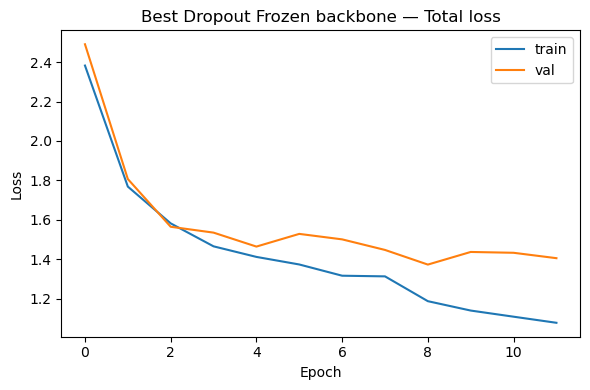

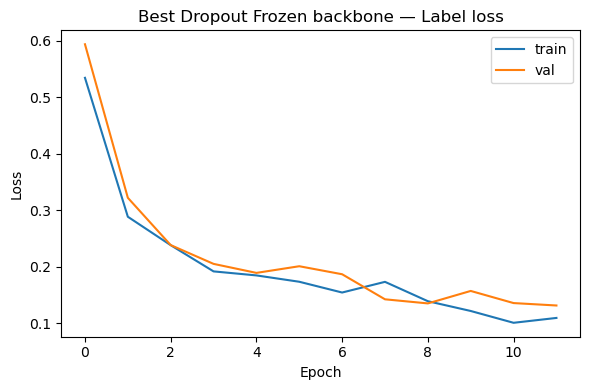

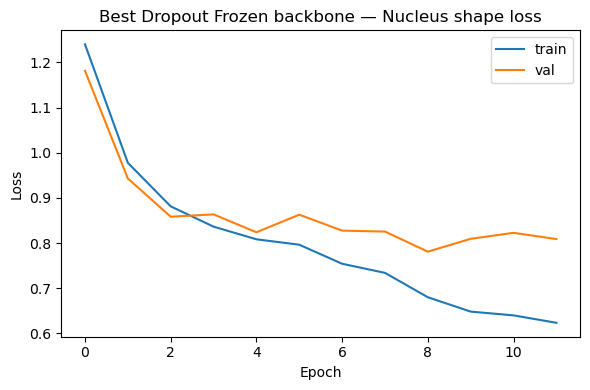

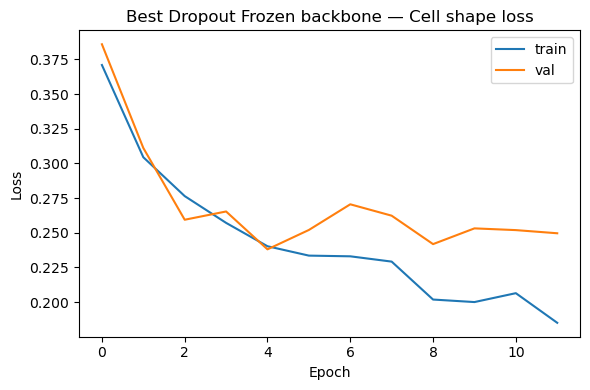

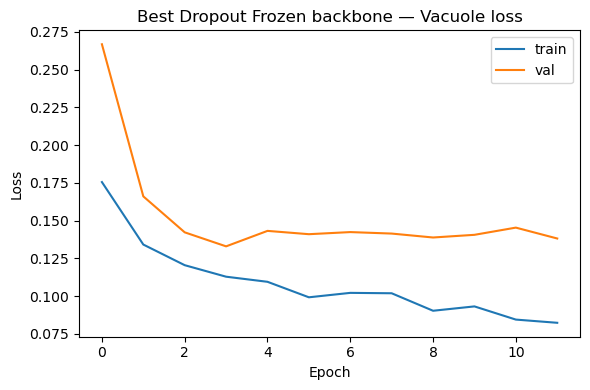

In [33]:
# For the frozen-backbone baseline:
plot_loss_curves(best_hist, title_prefix="Best Dropout Frozen backbone")

In [14]:
def confusion_matrices(model, ds, label_classes, nuc_classes,
                       thr_cell=0.5, thr_vac=0.5, split_name="Val"):
    """
    Compute confusion matrices for all heads on a tf.data.Dataset.
    Assumes dataset yields (x, y) where y is a dict with keys:
      'label' (one-hot), 'nucleus' (one-hot), 'cell' (0/1), 'vacuole' (0/1).
    Works even if your dataset yields (x, y, sample_weights) — weights are ignored here.

    Returns dict of numpy arrays.
    """
    y_true = {"label": [], "nucleus": [], "cell": [], "vacuole": []}
    y_pred = {"label": [], "nucleus": [], "cell": [], "vacuole": []}

    for batch in ds:
        # handle (x,y) or (x,y,weights)
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            xb, yb = batch[0], batch[1]
        else:
            xb, yb = batch

        # model predictions (numpy arrays)
        pl, pn, pc, pv = model.predict(xb, verbose=0)

        # ground-truth from dict yb (tensors)
        y_true["label"].extend(tf.argmax(yb["label"], axis=-1).numpy())
        y_true["nucleus"].extend(tf.argmax(yb["nucleus"], axis=-1).numpy())
        y_true["cell"].extend(tf.squeeze(yb["cell"], axis=-1).numpy())
        y_true["vacuole"].extend(tf.squeeze(yb["vacuole"], axis=-1).numpy())

        # predictions → argmax/threshold
        y_pred["label"].extend(np.argmax(pl, axis=-1))
        y_pred["nucleus"].extend(np.argmax(pn, axis=-1))
        y_pred["cell"].extend((pc.ravel() >= thr_cell).astype(int))
        y_pred["vacuole"].extend((pv.ravel() >= thr_vac).astype(int))

    # confusion matrices
    cm_label = confusion_matrix(y_true["label"],   y_pred["label"],   labels=list(range(len(label_classes))))
    cm_nuc   = confusion_matrix(y_true["nucleus"], y_pred["nucleus"], labels=list(range(len(nuc_classes))))
    cm_cell  = confusion_matrix(y_true["cell"],    y_pred["cell"],    labels=[0,1])
    cm_vac   = confusion_matrix(y_true["vacuole"], y_pred["vacuole"], labels=[0,1])

    # pretty print with class names
    print(f"\n[{split_name}] Confusion Matrix — label (rows=true, cols=pred):")
    print(pd.DataFrame(cm_label, index=label_classes, columns=label_classes))

    print(f"\n[{split_name}] Confusion Matrix — nucleus_shape (rows=true, cols=pred):")
    print(pd.DataFrame(cm_nuc, index=nuc_classes, columns=nuc_classes))

    print(f"\n[{split_name}] Confusion Matrix — cell_shape (rows=true [0=round,1=irregular]):")
    print(pd.DataFrame(cm_cell, index=[0,1], columns=[0,1]))

    print(f"\n[{split_name}] Confusion Matrix — vacuole (rows=true [0=no,1=yes]):")
    print(pd.DataFrame(cm_vac, index=[0,1], columns=[0,1]))

    return {
        "label": cm_label,
        "nucleus": cm_nuc,
        "cell": cm_cell,
        "vacuole": cm_vac
    }

In [38]:
cms_val = confusion_matrices(best_model, val_ds, label_classes, nuc_classes, split_name="Val")


[Val] Confusion Matrix — label (rows=true, cols=pred):
            Basophil  Eosinophil  Lymphocyte  Monocyte  Neutrophil
Basophil          88           1           3         2           0
Eosinophil         0         202           1         8          15
Lymphocyte         0           0          86         0           1
Monocyte           1           2           5        93           1
Neutrophil         0          12           0         0         229

[Val] Confusion Matrix — nucleus_shape (rows=true, cols=pred):
                      irregular  segmented-bilobed  segmented-multilobed  \
irregular                    45                  2                     0   
segmented-bilobed            18                153                    17   
segmented-multilobed          8                 45                    32   
unsegmented-band              3                 48                     2   
unsegmented-indented          6                  0                     1   
unsegmented-round     

2025-08-26 05:09:39.825153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
def make_balanced_train_df(
    train_df: pd.DataFrame,
    cols=("label", "nucleus_shape", "cell_shape", "cytoplasm_vacuole"),
    power=0.7,
    max_repeat=5,
    verbose=True,
):
    """
    Oversample minority classes across multiple columns.
    For each column, compute per-class repeat factor ~ (max_count / class_count)^power,
    then take the element-wise MAX of factors across all columns for each sample.
    Cap by max_repeat to avoid explosion.

    power in [0,1]: 
      0   -> no oversampling
      1.0 -> aggressive (full balancing)
    """
    df = train_df.copy()
    rep = np.ones(len(df), dtype=np.int32)

    def factors_for_col(series: pd.Series):
        vc = series.value_counts()
        m = vc.max()
        f_map = {k: int(np.clip(np.ceil((m / c) ** power), 1, max_repeat)) for k, c in vc.items()}
        return series.map(f_map).fillna(1).astype(int).values, f_map, vc

    stats = {}
    for col in cols:
        f_vec, f_map, vc = factors_for_col(df[col])
        rep = np.maximum(rep, f_vec)
        stats[col] = {"counts": vc.to_dict(), "factors": f_map}

    rep = np.clip(rep, 1, max_repeat).astype(int)
    df_bal = df.loc[df.index.repeat(rep)].reset_index(drop=True)

    if verbose:
        print("== Oversampling summary ==")
        for col in cols:
            print(f"\n[{col}] counts:", stats[col]["counts"])
            print(f"[{col}] factors:", stats[col]["factors"])
        print(f"\nOriginal train size: {len(train_df)}  →  Balanced size: {len(df_bal)}")
        # quick check: new distributions (still not perfectly flat, but closer)
        for col in cols:
            print(f"[balanced] {col} dist:", df_bal[col].value_counts(normalize=True).round(3).to_dict())
    return df_bal

# Example: build a balanced training frame, then your dataset as usual
train_bal_df = make_balanced_train_df(train_df, power=0.7, max_repeat=5, verbose=True)

# Rebuild the training dataset with augmentation ON (minority samples are now repeated more times,
# so they receive more *different* random augmentations across epochs)
train_ds_bal = make_ds(train_bal_df, shuffle=True, augment=True)

# val/test remain unchanged
val_ds_2   = make_ds(val_df,   shuffle=False, augment=False)
test_ds_2  = make_ds(test_df,  shuffle=False, augment=False)


== Oversampling summary ==

[label] counts: {'Neutrophil': 1127, 'Eosinophil': 1053, 'Monocyte': 475, 'Basophil': 440, 'Lymphocyte': 405}
[label] factors: {'Neutrophil': 1, 'Eosinophil': 2, 'Monocyte': 2, 'Basophil': 2, 'Lymphocyte': 3}

[nucleus_shape] counts: {'segmented-bilobed': 1040, 'unsegmented-band': 894, 'unsegmented-indented': 454, 'segmented-multilobed': 445, 'unsegmented-round': 357, 'irregular': 310}
[nucleus_shape] factors: {'segmented-bilobed': 1, 'unsegmented-band': 2, 'unsegmented-indented': 2, 'segmented-multilobed': 2, 'unsegmented-round': 3, 'irregular': 3}

[cell_shape] counts: {'round': 2719, 'irregular': 781}
[cell_shape] factors: {'round': 1, 'irregular': 3}

[cytoplasm_vacuole] counts: {'no': 3247, 'yes': 253}
[cytoplasm_vacuole] factors: {'no': 1, 'yes': 5}

Original train size: 3500  →  Balanced size: 8670
[balanced] label dist: {'Neutrophil': 0.284, 'Eosinophil': 0.255, 'Monocyte': 0.193, 'Lymphocyte': 0.14, 'Basophil': 0.128}
[balanced] nucleus_shape dist: 

In [ ]:
model_bal = build_model(dropout_rate=0.35)  # pick your dropout (or grid search later)
hist_bal  = model_bal.fit(
    train_ds_bal,
    validation_data=val_ds_2,
    epochs=40,
    callbacks=[val_cb, plateau_cb, early_cb],  # make sure val_cb comes first
    verbose=1
)


Epoch 1/40


2025-08-26 07:19:39.622763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 2075 of 8192
2025-08-26 07:19:49.625366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 4211 of 8192
2025-08-26 07:19:59.630257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 6338 of 8192
2025-08-26 07:20:08.370109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-08-26 07:20:08.572913: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1756192811.510022    1758 service.cc:145] XLA service 0x7f1210325060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756192811.510067    1758 service.cc:153]   StreamExecutor device (0): Tesla T4,

542/542 [==============================] - 111s 86ms/step - loss: 2.2111 - label_loss: 0.4247 - nucleus_loss: 1.1133 - cell_loss: 0.3789 - vacuole_loss: 0.2294 - val_loss: 1.6068 - val_label_loss: 0.2324 - val_nucleus_loss: 0.8875 - val_cell_loss: 0.2815 - val_vacuole_loss: 0.1363 - val_label_macro_f1: 0.9166 - val_nucleus_macro_f1: 0.6233 - val_cell_f1: 0.6691 - val_vacuole_f1: 0.6526 - val_overall: 0.7154 - lr: 0.0010
Epoch 2/40


2025-08-26 07:20:58.666179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 07:21:09.052441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 2146 of 8192
2025-08-26 07:21:19.051998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 4369 of 8192


  1/542 [..............................] - ETA: 5:37:08 - loss: 1.9011 - label_loss: 0.2409 - nucleus_loss: 0.9521 - cell_loss: 0.2894 - vacuole_loss: 0.3496

2025-08-26 07:21:36.238238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


542/542 [==============================] - ETA: 0s - loss: 1.7432 - label_loss: 0.2725 - nucleus_loss: 0.9000 - cell_loss: 0.3153 - vacuole_loss: 0.1824